In [1]:
import hydrofunctions as hf
import pandas as pd
import matplotlib
import numpy as np
import os
import pycwt as wavelet
from pycwt.helpers import find
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("ticks")

In [2]:
# USGS 04216000
site = '04216000'
start = '1928-01-01'
end = '2019-01-01'
response = hf.get_nwis(site, 'dv',start, end)

In [3]:
discharge = hf.extract_nwis_df(response.json())
discharge['Flow, CFS']=discharge['USGS:'+site+':00060:00003']

In [4]:
discharge= discharge.reset_index()
discharge['Date']  = discharge['datetime']
discharge['Date'] =pd.to_datetime(discharge['Date'], errors='coerce')
discharge = discharge[['Date', 'Flow, CFS']]
discharge['Source'] = 'USGS-'+site

In [5]:
discharge['Discharge, cms'] = 0.028*discharge['Flow, CFS']

In [6]:
site = 'USGS-'+site

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Year')

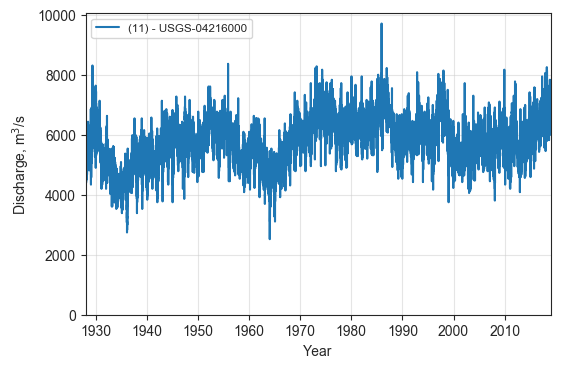

In [7]:
fig,ax=plt.subplots(1,1,figsize=(6,4), dpi=100)
ax=sns.lineplot(x='Date', y='Discharge, cms', data=discharge, hue='Source',ax=ax)

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes


# ax.legend(['({}) - {}'.format(selected_stations.index(site)+1, site)], loc=2, fontsize='small')
ax.legend(['(11) - '+site], loc=2, fontsize='small')
ax.set_ylim(0,None)
ax.set_xlim(datetime.datetime(1928,1,1), datetime.datetime(2019,1,1))
ax.grid(alpha=0.5)
ax.set_ylabel("Discharge, m$^3$/s")
ax.set_xlabel("Year")

# axins = zoomed_inset_axes(ax, 8, loc='upper center')
# sns.lineplot(x='Date', y='Discharge, cms', data=discharge, hue='Source', ax=axins,zorder=10)
# axins.set_xlim(datetime.datetime(2010,4,1), datetime.datetime(2010,6,1)) # apply the x-limits
# axins.set_ylim(0, 10) # apply the y-limits
# plt.yticks(visible=False)
# plt.xticks(visible=False)
# from mpl_toolkits.axes_grid1.inset_locator import mark_inset
# mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")




In [8]:
discharge['Year_dec'] = discharge['Date'].dt.year+ (discharge['Date'].dt.dayofyear -1)/365

In [9]:
df = discharge.set_index('Date')
df= df.resample("M", how='mean')

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  


In [10]:
Niagara_flow = pd.read_excel('../../measurements/USGS stream data/Niagara_annual_cfs.xlsx')

Niagara_flow['CFS'].values

Niagara_flow['CFS'] = pd.to_numeric(Niagara_flow['CFS'], errors='coerce')
Niagara_flow['Water Year'] = pd.to_numeric(Niagara_flow['Water Year'], errors='coerce')


In [11]:
# t = discharge['Year_dec'].values
t = df['Year_dec'].values
# t = Niagara_flow['Water Year'].values
t0 = t[0]
dt=1/12
dat = df['Discharge, cms'].values
# dat = Niagara_flow['CFS'].values
N = dat.size

We write the following code to detrend and normalize the input data by its standard deviation. Sometimes detrending is not necessary and simply removing the mean value is good enough. However, if your dataset has a well defined trend, such as the Mauna Loa CO2 dataset available in the above mentioned website, it is strongly advised to perform detrending. Here, we fit a one-degree polynomial function and then subtract it from the original data.

In [12]:
p = np.polyfit(t - t0, dat, 1)
dat_notrend = dat - np.polyval(p, t - t0)
std = dat_notrend.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset

Text(0.5, 0, 'Year')

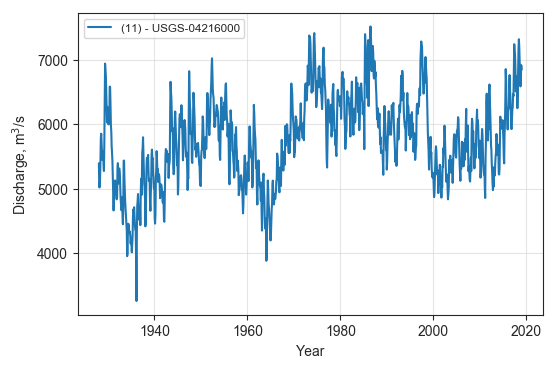

In [13]:
fig,ax=plt.subplots(1,1,figsize=(6,4), dpi=100)
ax=sns.lineplot(t, dat,ax=ax)

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes


# ax.legend(['({}) - {}'.format(selected_stations.index(site)+1, site)], loc=2, fontsize='small')
ax.legend(['(11) - '+site], loc=2, fontsize='small')
# ax.set_ylim(0,None)
# ax.set_xlim(datetime.datetime(1928,1,1), datetime.datetime(2019,1,1))
ax.grid(alpha=0.5)
ax.set_ylabel("Discharge, m$^3$/s")
ax.set_xlabel("Year")

# axins = zoomed_inset_axes(ax, 8, loc='upper center')
# sns.lineplot(x='Date', y='Discharge, cms', data=discharge, hue='Source', ax=axins,zorder=10)
# axins.set_xlim(datetime.datetime(2010,4,1), datetime.datetime(2010,6,1)) # apply the x-limits
# axins.set_ylim(0, 10) # apply the y-limits
# plt.yticks(visible=False)
# plt.xticks(visible=False)
# from mpl_toolkits.axes_grid1.inset_locator import mark_inset
# mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")




The next step is to define some parameters of our wavelet analysis. We select the mother wavelet, in this case the Morlet wavelet with ω0=6.

In [14]:
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 8 / dj  # Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

The following routines perform the wavelet transform and inverse wavelet transform using the parameters defined above. Since we have normalized our input time-series, we multiply the inverse transform by the standard deviation.

In [15]:
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

We calculate the normalized wavelet and Fourier power spectra, as well as the Fourier equivalent periods for each wavelet scale.

In [16]:
power = (np.abs(wave)) ** 2
fft_power = np.abs(fft) ** 2
period = 1 / freqs

Optionally, we could also rectify the power spectrum according to the suggestions proposed by Liu et al. (2007)[2]

In [17]:
power = power/scales[:, None]

In [18]:
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = np.ones([1, N]) * signif[:, None]
sig95 = power / sig95

Then, we calculate the global wavelet spectrum and determine its significance level.

In [19]:
glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

In [20]:
sel = find((period >= 0.5) & (period <= 1.5))
Cdelta = mother.cdelta
scale_avg = (scales * np.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)


sel = find((period >= 2) & (period <= 8))
Cdelta = mother.cdelta
scale_avg_2 = (scales * np.ones((N, 1))).transpose()
scale_avg_2 = power / scale_avg_2  # As in Torrence and Compo (1998) equation 24
scale_avg_2 = var * dj * dt / Cdelta * scale_avg_2[sel, :].sum(axis=0)
scale_avg_signif_2, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

sel = find((period >= 8) & (period <= 16))
Cdelta = mother.cdelta
scale_avg_3 = (scales * np.ones((N, 1))).transpose()
scale_avg_3 = power / scale_avg_3  # As in Torrence and Compo (1998) equation 24
scale_avg_3 = var * dj * dt / Cdelta * scale_avg_3[sel, :].sum(axis=0)
scale_avg_signif_2, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

In [21]:
units = 'cms'

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


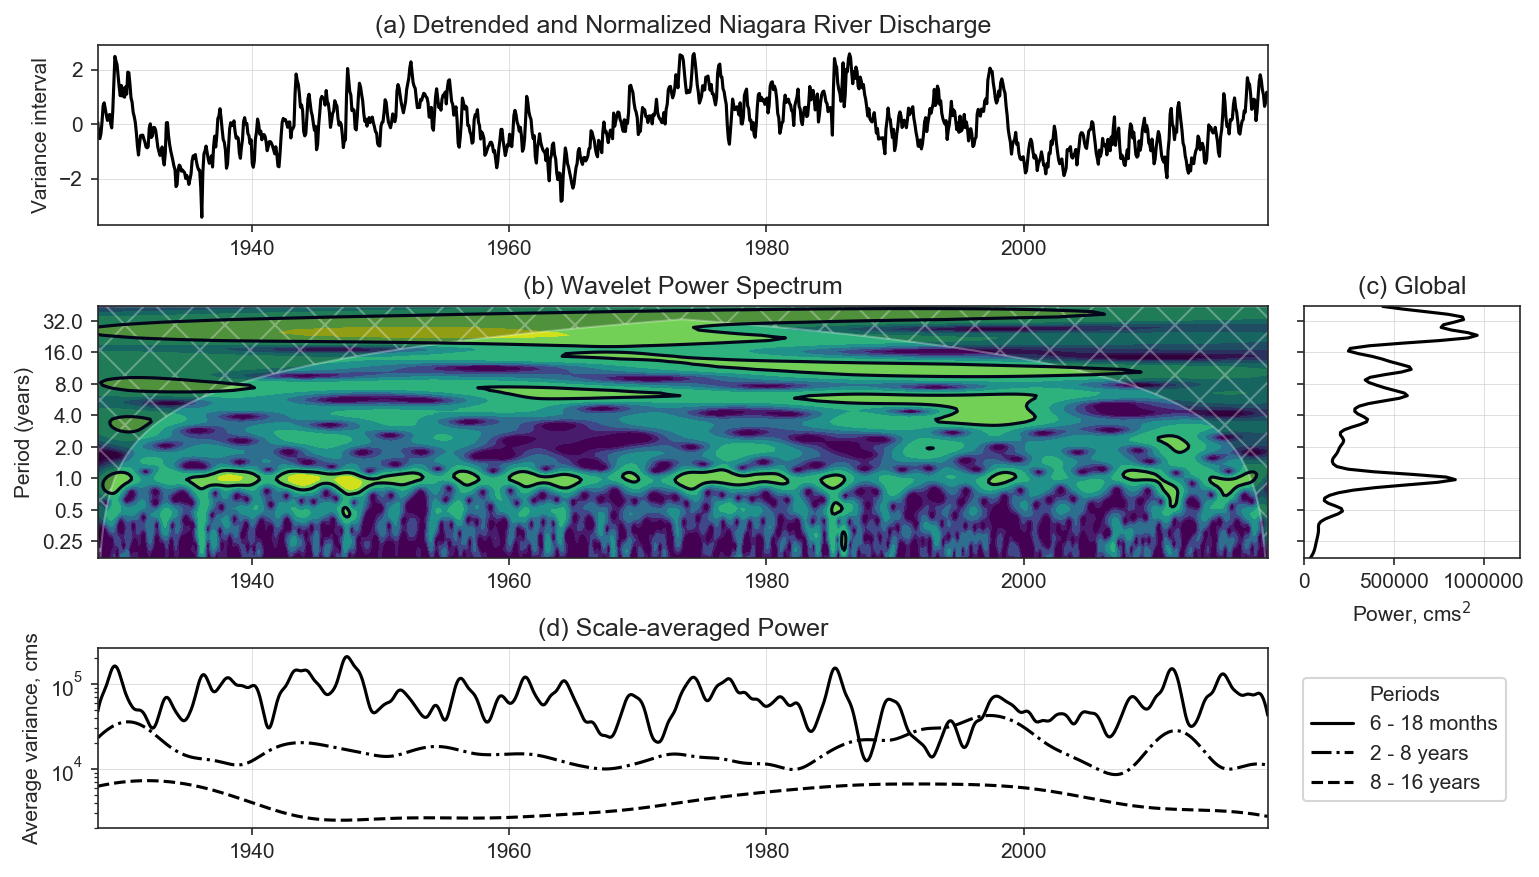

In [22]:
# Prepare the figure
plt.close('all')
plt.ioff()
figprops = dict(figsize=(12, 6), dpi=150)
fig = plt.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
# ax = plt.axes([0.1, 0.8, 0.65, 0.18])
# ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
# ax.plot(t, dat, 'k', linewidth=1.5)
# # ax.set_title('a) {}'.format(title))
# # ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = plt.axes([0.1, 0.38, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
            extend='both', cmap=plt.cm.viridis)
# bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels), colors='k', linewidths=2)
extent = [t.min(), t.max(), 0, max(period)]

bx.contour(t, np.log2(period), np.log2(power), np.log2([2]))

# bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
#            extent=extent)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                           np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('(b) Wavelet Power Spectrum')
bx.set_ylabel('Period (years)')
#
Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                           np.ceil(np.log2(period.max())))
# Yticks = 2 ** np.arange(np.ceil(np.log2(0.25)),
#                            np.ceil(np.log2(32.01)))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)


# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = plt.axes([0.77, 0.38, 0.12, 0.28], sharey=bx)
# cx.plot(glbl_signif, np.log2(period), 'k--')
# cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
# cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',linewidth=1.)
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
cx.set_title('(c) Global')
cx.set_xlabel(r'Power, cms$^2$')
cx.set_xlim([0, glbl_power.max() + 3*var])
# cx.set_xlim([0, 0.5])
cx.set_ylim(np.log2([period.min(), period.max()]))
# cx.set_ylim(np.log2([0.25, 32.01]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
plt.setp(cx.get_yticklabels(), visible=False)
cx.grid(lw=0.3)


# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = plt.axes([0.1, 0.08, 0.65, 0.20], sharex=ax)
# dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.semilogy(t, scale_avg, 'k-', linewidth=1.5, label='6 - 18 months')
dx.semilogy(t, scale_avg_2, 'k-.', linewidth=1.5, label='2 - 8 years')
dx.semilogy(t, scale_avg_3, 'k--', linewidth=1.5, label='8 - 16 years')
dx.set_title('(d) Scale-averaged Power'.format(0.5, 1.5))
# dx.set_xlabel('Time (year)')
dx.legend(loc=(1.03,0.15), title='Periods')
dx.set_ylabel(r'Average variance, {}'.format(units))
ax.set_xlim([t.min(), t.max()])
dx.grid(lw=0.3)

# Fourth sub-plot, the scale averaged wavelet spectrum.
fx = plt.axes([0.1, 0.75, 0.65, 0.20], sharex=ax)
# dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
# fx.plot(t, scale_avg_2, 'k-', linewidth=1.5)
# fx.set_title('{}--{} year scale-averaged power'.format(3, 16))
# fx.set_xlabel('Time (year)')
# fx.set_ylabel(r'Average variance, {}'.format(units))
# # dx.set_ylabel(r'Average variance [{}]'.format(units))
# # fx.set_xlim([t.min(), t.max()])
# fx.grid(lw=0.3)

# ex = plt.axes([0.68, 0.14, 0.35, 0.45])
fx=sns.lineplot(t, dat_norm,ax=fx, c='k')
fx.set_title('(a) Detrended and Normalized Niagara River Discharge')
fx.set_ylabel(r'Variance interval')
# fx.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
# fx.plot(t, dat, 'k', linewidth=1.5)
fx.grid(lw=0.3)
fx.set_xlim([t.min(), t.max()])
plt.tight_layout()

# fig.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Water Budget/latex_figures/img/freq_analysis_niagara.pdf', dpi=fig.dpi)




# Water Level

In [23]:
water_level_2 = pd.read_excel('../../measurements/Great_Lakes_Watrer_Level_monthlyAve.xlsx', skiprows=12)

In [24]:
water_level_2['Year_dec'] = 1918 + water_level_2.index/12

Text(0.5, 0, 'Year')

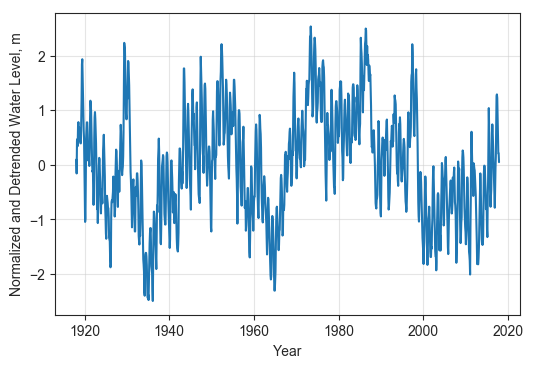

In [25]:
# t = discharge['Year_dec'].values
t = water_level_2['Year_dec'].values
# t = Niagara_flow['Water Year'].values
t0 = t[0]
dt=1/12
dat = water_level_2['Erie'].values
# dat = Niagara_flow['CFS'].values
N = dat.size

p = np.polyfit(t - t0, dat, 1)
dat_notrend = dat - np.polyval(p, t - t0)
std = dat_notrend.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset

fig,ax=plt.subplots(1,1,figsize=(6,4), dpi=100)
ax=sns.lineplot(t, dat_norm,ax=ax)

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes


# ax.legend(['({}) - {}'.format(selected_stations.index(site)+1, site)], loc=2, fontsize='small')
# ax.legend(['(11) - '+site], loc=2, fontsize='small')
# ax.set_ylim(0,None)
# ax.set_xlim(datetime.datetime(1928,1,1), datetime.datetime(2019,1,1))
ax.grid(alpha=0.5)
ax.set_ylabel("Normalized and Detrended Water Level, m")
ax.set_xlabel("Year")

# axins = zoomed_inset_axes(ax, 8, loc='upper center')
# sns.lineplot(x='Date', y='Discharge, cms', data=discharge, hue='Source', ax=axins,zorder=10)
# axins.set_xlim(datetime.datetime(2010,4,1), datetime.datetime(2010,6,1)) # apply the x-limits
# axins.set_ylim(0, 10) # apply the y-limits
# plt.yticks(visible=False)
# plt.xticks(visible=False)
# from mpl_toolkits.axes_grid1.inset_locator import mark_inset
# mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")




In [26]:
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 8 / dj  # Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

power = (np.abs(wave)) ** 2
fft_power = np.abs(fft) ** 2
period = 1 / freqs

power = power/scales[:, None]

signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = np.ones([1, N]) * signif[:, None]
sig95 = power / sig95

glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

sel = find((period >= 0.5) & (period <= 1.5))
Cdelta = mother.cdelta
scale_avg = (scales * np.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)


sel = find((period >= 2) & (period <= 8))
Cdelta = mother.cdelta
scale_avg_2 = (scales * np.ones((N, 1))).transpose()
scale_avg_2 = power / scale_avg_2  # As in Torrence and Compo (1998) equation 24
scale_avg_2 = var * dj * dt / Cdelta * scale_avg_2[sel, :].sum(axis=0)
scale_avg_signif_2, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

sel = find((period >= 8) & (period <= 16))
Cdelta = mother.cdelta
scale_avg_3 = (scales * np.ones((N, 1))).transpose()
scale_avg_3 = power / scale_avg_3  # As in Torrence and Compo (1998) equation 24
scale_avg_3 = var * dj * dt / Cdelta * scale_avg_3[sel, :].sum(axis=0)
scale_avg_signif_2, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

In [27]:
units = 'm'

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


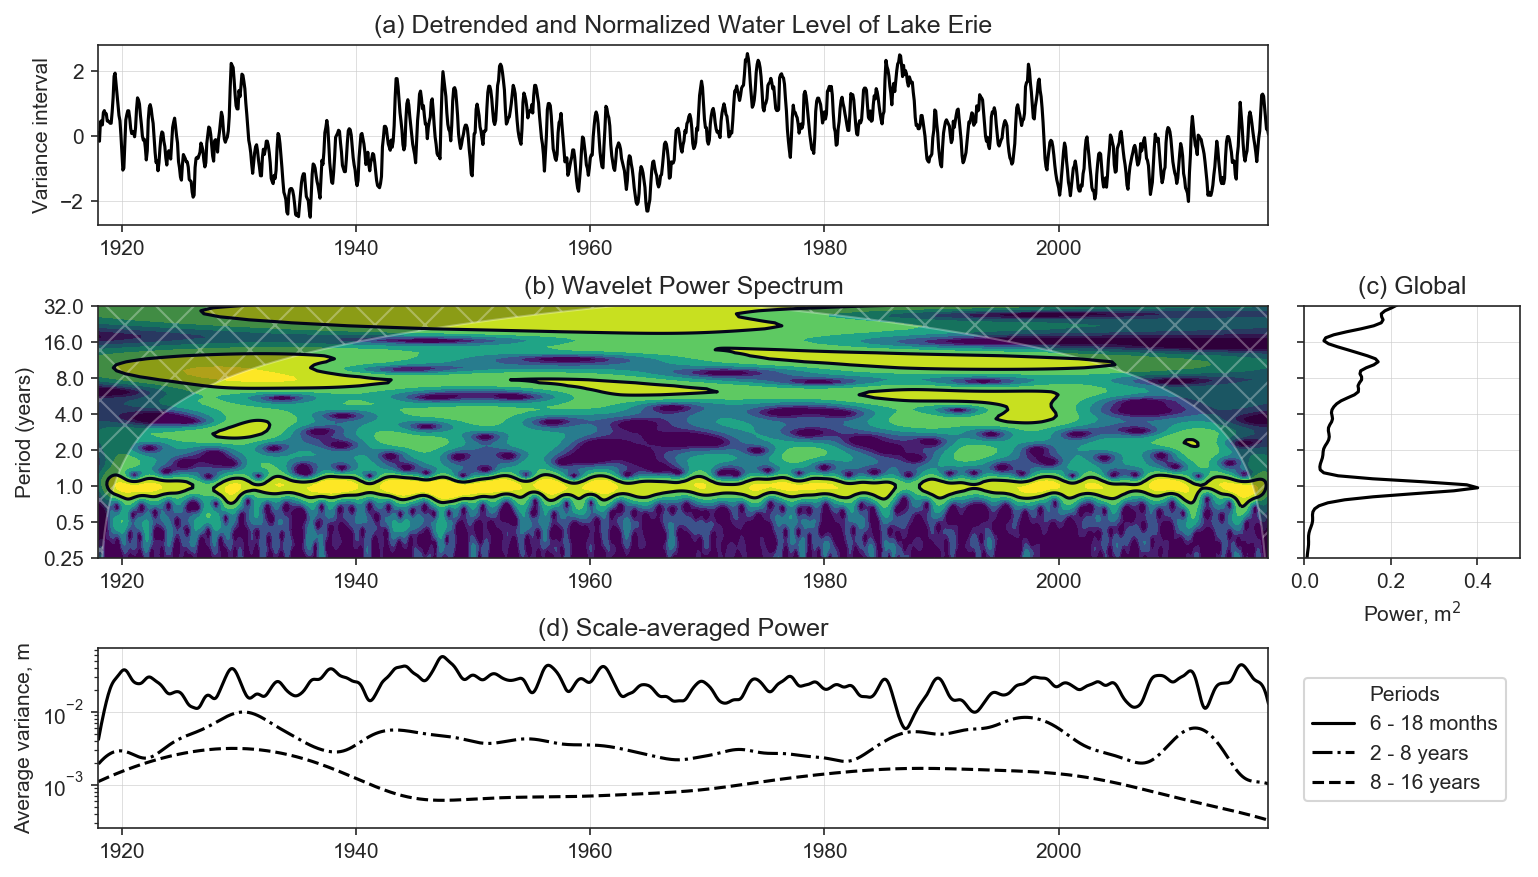

In [28]:
# Prepare the figure
plt.close('all')
plt.ioff()
figprops = dict(figsize=(12, 6), dpi=150)
fig = plt.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
# ax = plt.axes([0.1, 0.8, 0.65, 0.18])
# ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
# ax.plot(t, dat, 'k', linewidth=1.5)
# # ax.set_title('a) {}'.format(title))
# # ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = plt.axes([0.1, 0.38, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4]
bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
            extend='both', cmap=plt.cm.viridis)
# bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels), colors='k', linewidths=2)
extent = [t.min(), t.max(), 0, max(period)]

bx.contour(t, np.log2(period), np.log2(power), np.log2([2]))

# bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
#            extent=extent)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                           np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('(b) Wavelet Power Spectrum')
bx.set_ylabel('Period (years)')
#
# Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
#                            np.ceil(np.log2(period.max())))
Yticks = 2 ** np.arange(np.ceil(np.log2(0.25)),
                           np.ceil(np.log2(32.01)))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)


# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = plt.axes([0.77, 0.38, 0.12, 0.28], sharey=bx)
# cx.plot(glbl_signif, np.log2(period), 'k--')
# cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
# cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',linewidth=1.)
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
cx.set_title('(c) Global')
cx.set_xlabel(r'Power, m$^2$')
cx.set_xlim([0, glbl_power.max() + var])
cx.set_xlim([0, 0.5])
# cx.set_ylim(np.log2([period.min(), period.max()]))
cx.set_ylim(np.log2([0.25, 32.01]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
plt.setp(cx.get_yticklabels(), visible=False)
cx.grid(lw=0.3)


# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = plt.axes([0.1, 0.08, 0.65, 0.20], sharex=ax)
# dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.semilogy(t, scale_avg, 'k-', linewidth=1.5, label='6 - 18 months')
dx.semilogy(t, scale_avg_2, 'k-.', linewidth=1.5, label='2 - 8 years')
dx.semilogy(t, scale_avg_3, 'k--', linewidth=1.5, label='8 - 16 years')
dx.set_title('(d) Scale-averaged Power'.format(0.5, 1.5))
# dx.set_xlabel('Time (year)')
dx.legend(loc=(1.03,0.15), title='Periods')
dx.set_ylabel(r'Average variance, {}'.format(units))
ax.set_xlim([t.min(), t.max()])
dx.grid(lw=0.3)

# Fourth sub-plot, the scale averaged wavelet spectrum.
fx = plt.axes([0.1, 0.75, 0.65, 0.20], sharex=ax)
# dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
# fx.plot(t, scale_avg_2, 'k-', linewidth=1.5)
# fx.set_title('{}--{} year scale-averaged power'.format(3, 16))
# fx.set_xlabel('Time (year)')
# fx.set_ylabel(r'Average variance, {}'.format(units))
# # dx.set_ylabel(r'Average variance [{}]'.format(units))
# # fx.set_xlim([t.min(), t.max()])
# fx.grid(lw=0.3)

# ex = plt.axes([0.68, 0.14, 0.35, 0.45])
fx=sns.lineplot(t, dat_norm,ax=fx, c='k')
fx.set_title('(a) Detrended and Normalized Water Level of Lake Erie')
fx.set_ylabel(r'Variance interval')
# fx.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
# fx.plot(t, dat, 'k', linewidth=1.5)
fx.grid(lw=0.3)
fx.set_xlim([t.min(), t.max()])
plt.tight_layout()

# fig.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Water Budget/latex_figures/img/freq_analysis_water_level.pdf', dpi=fig.dpi)




In [30]:
wl_t, wl_scale_avg  = t, scale_avg 
wl_t, wl_scale_avg_2 = t, scale_avg_2
wl_t, wl_scale_avg_3 = t, scale_avg_3

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


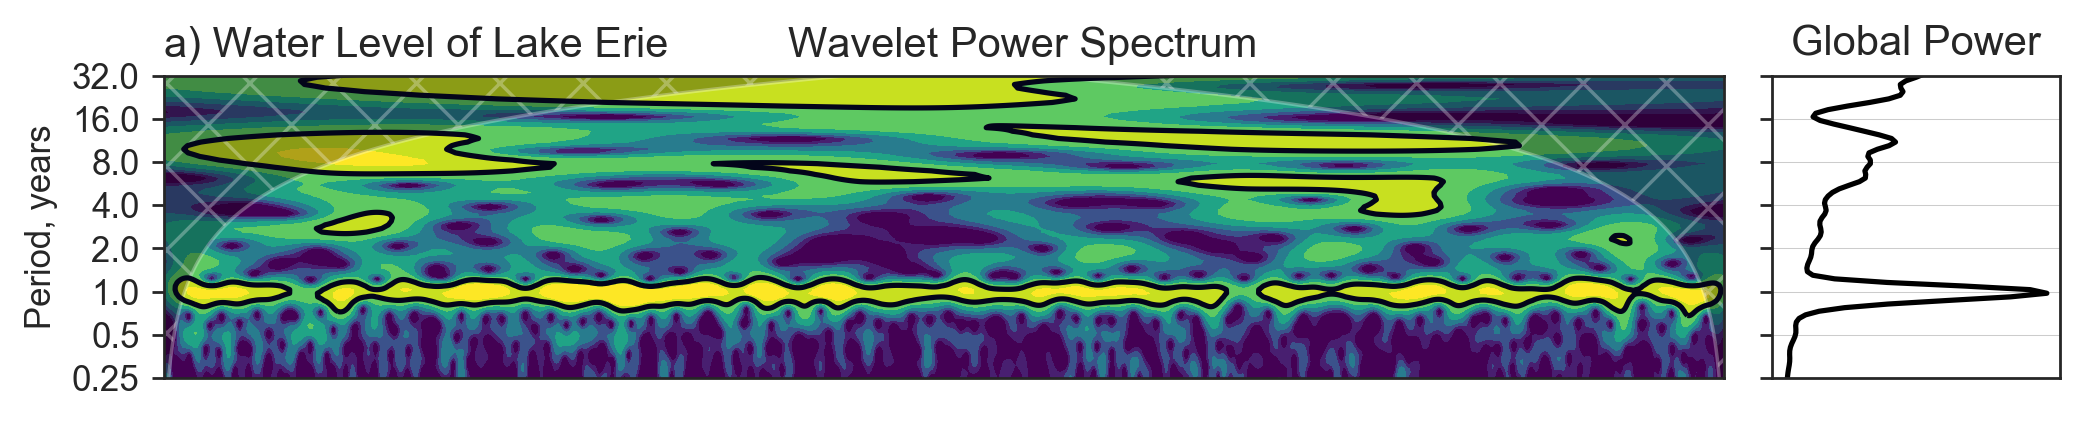

In [31]:
plt.close('all')
plt.ioff()
figprops = dict(figsize=(8*1.2, 1.6*1.2), dpi=250)
fig = plt.figure(**figprops)
bx = plt.axes([0.1, 0.2, 0.65, 0.63], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, ]
bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
            extend='both', cmap=plt.cm.viridis)
# bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels), colors='k', linewidths=2)
extent = [t.min(), t.max(), 0, max(period)]

bx.contour(t, np.log2(period), np.log2(power), np.log2([2]))

# bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
#            extent=extent)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                           np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.text(0,1.1, 'a) Water Level of Lake Erie', horizontalalignment='left', verticalalignment='center', transform=bx.transAxes, fontsize='large')
bx.text(0.4,1.1, 'Wavelet Power Spectrum', horizontalalignment='left', verticalalignment='center', transform=bx.transAxes, fontsize='large')
# bx.set_title('Wavelet Power Spectrum')
bx.set_ylabel('Period, years')
#
# Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
#                            np.ceil(np.log2(period.max())))
Yticks = 2 ** np.arange(np.ceil(np.log2(0.25)),
                           np.ceil(np.log2(32.01)))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)
bx.set_xticks(np.arange(1920,2020,10))
bx.set_xticks([])

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = plt.axes([0.77, 0.2, 0.12, 0.63], sharey=bx)
# cx.plot(glbl_signif, np.log2(period), 'k--')
# cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
# cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',linewidth=1.)
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
cx.set_title('Global Power')
# cx.set_xlabel(r'Power')
# cx.set_xlim([0, glbl_power.max() + var])
# cx.set_xlim([0, glbl_power.max()/var/10])
cx.set_xticks([])
# cx.set_ylim(np.log2([period.min(), period.max()]))
cx.set_ylim(np.log2([0.25, 32.01]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
plt.setp(cx.get_yticklabels(), visible=False)
cx.grid(lw=0.3)
plt.tight_layout()
# fig.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Water Budget/latex_figures/img/freq_wl.pdf', dpi=fig.dpi)




# Runoff



In [32]:
Runoff_mm = pd.read_excel('../../measurements/glerl/Runoff.xlsx', sheetname='ERI_mm', skiprows=4)

Runoff_mm['Ann'] = pd.to_numeric(Runoff_mm['Ann'], errors='coerce')
Runoff_mm['YEAR'] = pd.to_numeric(Runoff_mm['YEAR'], errors='coerce')

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [33]:
Runoff_mm_agg = Runoff_mm.groupby('YEAR').mean()[Runoff_mm.columns[1:-1]].stack().reset_index()

Runoff_mm_agg['M_n'] = Runoff_mm_agg['level_1'].apply(lambda x: datetime.datetime.strptime(x, '%b').month)

Runoff_mm_agg['Year_dec']= Runoff_mm_agg['YEAR'] + Runoff_mm_agg['M_n']/12

Text(0.5, 0, 'Year')

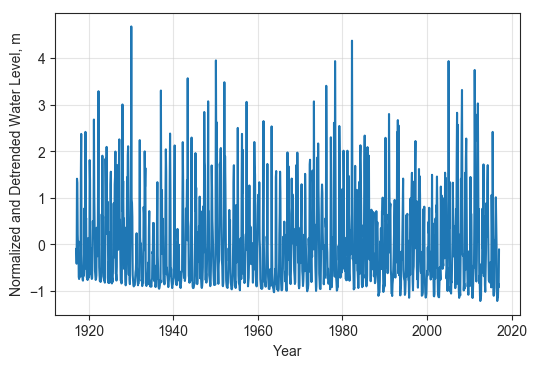

In [34]:
# t = discharge['Year_dec'].values
t = Runoff_mm_agg[Runoff_mm_agg['YEAR']>1916.99]['Year_dec'].values
# t = Niagara_flow['Water Year'].values
t0 = t[0]
dt=1/12
dat = Runoff_mm_agg[Runoff_mm_agg['YEAR']>1916.99][0]
# dat = Niagara_flow['CFS'].values
N = dat.size

p = np.polyfit(t - t0, dat, 1)
dat_notrend = dat - np.polyval(p, t - t0)
std = dat_notrend.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset

fig,ax=plt.subplots(1,1,figsize=(6,4), dpi=100)
ax=sns.lineplot(t, dat_norm,ax=ax)

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes


# ax.legend(['({}) - {}'.format(selected_stations.index(site)+1, site)], loc=2, fontsize='small')
# ax.legend(['(11) - '+site], loc=2, fontsize='small')
# ax.set_ylim(0,None)
# ax.set_xlim(datetime.datetime(1928,1,1), datetime.datetime(2019,1,1))
ax.grid(alpha=0.5)
ax.set_ylabel("Normalized and Detrended Water Level, m")
ax.set_xlabel("Year")

# axins = zoomed_inset_axes(ax, 8, loc='upper center')
# sns.lineplot(x='Date', y='Discharge, cms', data=discharge, hue='Source', ax=axins,zorder=10)
# axins.set_xlim(datetime.datetime(2010,4,1), datetime.datetime(2010,6,1)) # apply the x-limits
# axins.set_ylim(0, 10) # apply the y-limits
# plt.yticks(visible=False)
# plt.xticks(visible=False)
# from mpl_toolkits.axes_grid1.inset_locator import mark_inset
# mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")




In [35]:
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 8 / dj  # Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

power = (np.abs(wave)) ** 2
fft_power = np.abs(fft) ** 2
period = 1 / freqs

power = power/scales[:, None]

signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = np.ones([1, N]) * signif[:, None]
sig95 = power / sig95

glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

sel = find((period >= 0.5) & (period <= 1.5))
Cdelta = mother.cdelta
scale_avg = (scales * np.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)


sel = find((period >= 2) & (period <= 8))
Cdelta = mother.cdelta
scale_avg_2 = (scales * np.ones((N, 1))).transpose()
scale_avg_2 = power / scale_avg_2  # As in Torrence and Compo (1998) equation 24
scale_avg_2 = var * dj * dt / Cdelta * scale_avg_2[sel, :].sum(axis=0)
scale_avg_signif_2, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

sel = find((period >= 8) & (period <= 16))
Cdelta = mother.cdelta
scale_avg_3 = (scales * np.ones((N, 1))).transpose()
scale_avg_3 = power / scale_avg_3  # As in Torrence and Compo (1998) equation 24
scale_avg_3 = var * dj * dt / Cdelta * scale_avg_3[sel, :].sum(axis=0)
scale_avg_signif_2, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

In [36]:
units = 'mm'

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


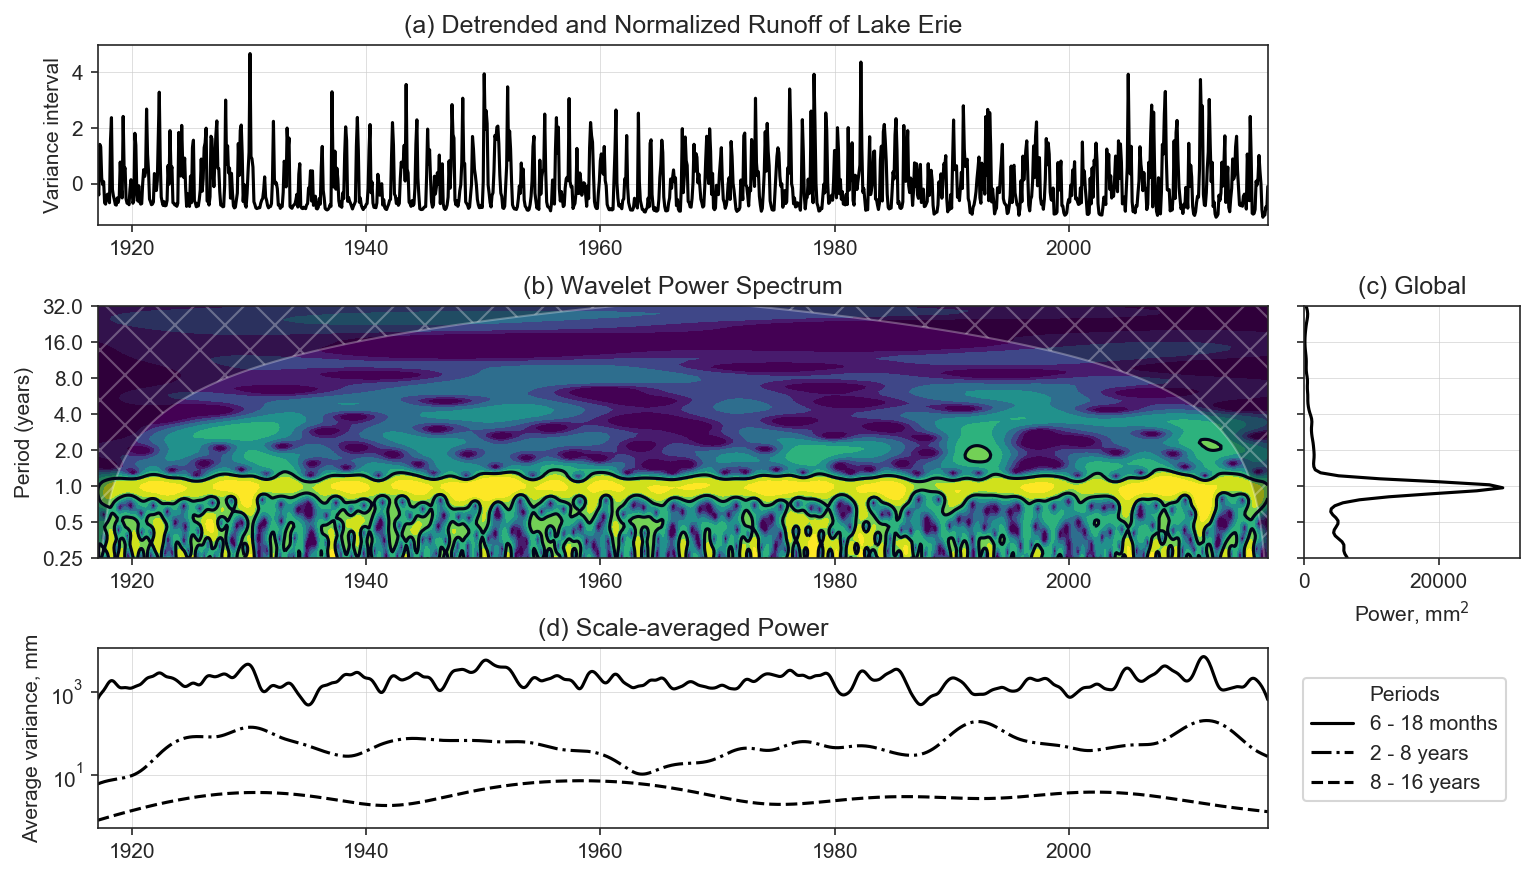

In [37]:
# Prepare the figure
plt.close('all')
plt.ioff()
figprops = dict(figsize=(12, 6), dpi=150)
fig = plt.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
# ax = plt.axes([0.1, 0.8, 0.65, 0.18])
# ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
# ax.plot(t, dat, 'k', linewidth=1.5)
# # ax.set_title('a) {}'.format(title))
# # ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = plt.axes([0.1, 0.38, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
            extend='both', cmap=plt.cm.viridis)
# bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels), colors='k', linewidths=2)
extent = [t.min(), t.max(), 0, max(period)]

bx.contour(t, np.log2(period), np.log2(power), np.log2([2]))

# bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
#            extent=extent)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                           np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('(b) Wavelet Power Spectrum')
bx.set_ylabel('Period (years)')
#
# Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
#                            np.ceil(np.log2(period.max())))
Yticks = 2 ** np.arange(np.ceil(np.log2(0.25)),
                           np.ceil(np.log2(32.01)))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)


# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = plt.axes([0.77, 0.38, 0.12, 0.28], sharey=bx)
# cx.plot(glbl_signif, np.log2(period), 'k--')
# cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
# cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',linewidth=1.)
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
cx.set_title('(c) Global')
cx.set_xlabel(r'Power, mm$^2$')
cx.set_xlim([0, glbl_power.max() + 10*var])
# cx.set_xlim([0, 0.5])
# cx.set_ylim(np.log2([period.min(), period.max()]))
cx.set_ylim(np.log2([0.25, 32.01]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
plt.setp(cx.get_yticklabels(), visible=False)
cx.grid(lw=0.3)


# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = plt.axes([0.1, 0.08, 0.65, 0.20], sharex=ax)
# dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.semilogy(t, scale_avg, 'k-', linewidth=1.5, label='6 - 18 months')
dx.semilogy(t, scale_avg_2, 'k-.', linewidth=1.5, label='2 - 8 years')
dx.semilogy(t, scale_avg_3, 'k--', linewidth=1.5, label='8 - 16 years')
dx.set_title('(d) Scale-averaged Power'.format(0.5, 1.5))
# dx.set_xlabel('Time (year)')
dx.legend(loc=(1.03,0.15), title='Periods')
dx.set_ylabel(r'Average variance, {}'.format(units))
ax.set_xlim([t.min(), t.max()])
dx.grid(lw=0.3)

# Fourth sub-plot, the scale averaged wavelet spectrum.
fx = plt.axes([0.1, 0.75, 0.65, 0.20], sharex=ax)
# dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
# fx.plot(t, scale_avg_2, 'k-', linewidth=1.5)
# fx.set_title('{}--{} year scale-averaged power'.format(3, 16))
# fx.set_xlabel('Time (year)')
# fx.set_ylabel(r'Average variance, {}'.format(units))
# # dx.set_ylabel(r'Average variance [{}]'.format(units))
# # fx.set_xlim([t.min(), t.max()])
# fx.grid(lw=0.3)

# ex = plt.axes([0.68, 0.14, 0.35, 0.45])
fx=sns.lineplot(t, dat_norm,ax=fx, c='k')
fx.set_title('(a) Detrended and Normalized Runoff of Lake Erie')
fx.set_ylabel(r'Variance interval')
# fx.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
# fx.plot(t, dat, 'k', linewidth=1.5)
fx.grid(lw=0.3)
# fx.set_xlim([t.min(), t.max()])
fx.set_xlim([t.min(), t.max()])
plt.tight_layout()

# fig.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Water Budget/latex_figures/img/freq_analysis_runoff.pdf', dpi=fig.dpi)




In [38]:
rf_t, rf_scale_avg  = t, scale_avg 
rf_t, rf_scale_avg_2 = t, scale_avg_2
rf_t, rf_scale_avg_3 = t, scale_avg_3

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


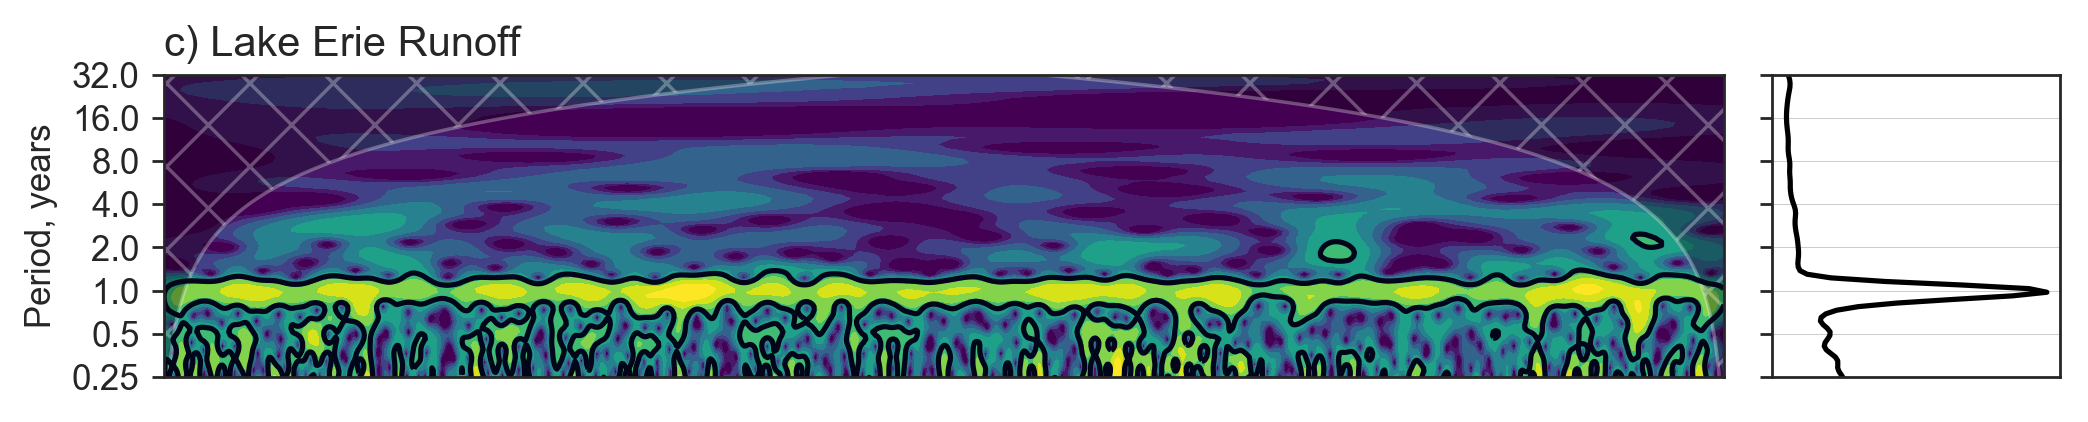

In [39]:
plt.close('all')
plt.ioff()
figprops = dict(figsize=(8*1.2, 1.6*1.2), dpi=250)
fig = plt.figure(**figprops)
bx = plt.axes([0.1, 0.2, 0.65, 0.63], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
            extend='both', cmap=plt.cm.viridis)
# bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels), colors='k', linewidths=2)
extent = [t.min(), t.max(), 0, max(period)]

bx.contour(t, np.log2(period), np.log2(power), np.log2([2]))

# bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
#            extent=extent)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                           np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.text(0,1.1, 'c) Lake Erie Runoff', horizontalalignment='left', verticalalignment='center', transform=bx.transAxes, fontsize='large')
# bx.set_title('Wavelet Power Spectrum')
bx.set_ylabel('Period, years')
#
# Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
#                            np.ceil(np.log2(period.max())))
Yticks = 2 ** np.arange(np.ceil(np.log2(0.25)),
                           np.ceil(np.log2(32.01)))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)
bx.set_xticks(np.arange(1920,2020,10))
bx.set_xticks([])

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = plt.axes([0.77, 0.2, 0.12, 0.63], sharey=bx)
# cx.plot(glbl_signif, np.log2(period), 'k--')
# cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
# cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',linewidth=1.)
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
# cx.set_title('Global Power')
# cx.set_xlabel(r'Power')
# cx.set_xlim([0, glbl_power.max() + var])
# cx.set_xlim([0, glbl_power.max()/var/10])
cx.set_xticks([])
# cx.set_ylim(np.log2([period.min(), period.max()]))
cx.set_ylim(np.log2([0.25, 32.01]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
plt.setp(cx.get_yticklabels(), visible=False)
cx.grid(lw=0.3)
plt.tight_layout()
# fig.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Water Budget/latex_figures/img/freq_runoff.pdf', dpi=fig.dpi)




# Precipitation

In [57]:
Precip_mm = pd.read_excel('../../measurements/glerl/Precip_Lake.xlsx', sheetname='ERI_mm', skiprows=3)
Precip_mm['Total'] = pd.to_numeric(Precip_mm['Total'], errors='coerce')
Precip_mm['Year'] = pd.to_numeric(Precip_mm['Year'], errors='coerce')

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [58]:
Precip_mm_agg = Precip_mm.groupby('Year').mean()[Precip_mm.columns[1:-1]].stack().reset_index()

Precip_mm_agg['M_n'] = Precip_mm_agg['level_1'].apply(lambda x: datetime.datetime.strptime(x, '%b').month)

Precip_mm_agg['Year_dec']= Precip_mm_agg['Year'] + Precip_mm_agg['M_n']/12

Text(0.5, 0, 'Year')

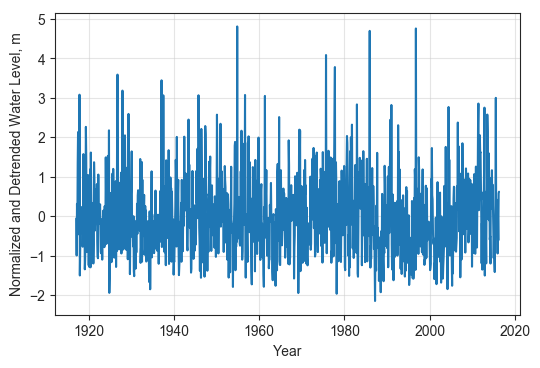

In [59]:
# t = discharge['Year_dec'].values
t = Precip_mm_agg[Precip_mm_agg['Year']>1916.99]['Year_dec'].values
# t = Niagara_flow['Water Year'].values
t0 = t[0]
dt=1/12
dat = Precip_mm_agg[Precip_mm_agg['Year']>1916.99][0]
# dat = Niagara_flow['CFS'].values
N = dat.size

p = np.polyfit(t - t0, dat, 1)
dat_notrend = dat - np.polyval(p, t - t0)
std = dat_notrend.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset

fig,ax=plt.subplots(1,1,figsize=(6,4), dpi=100)
ax=sns.lineplot(t, dat_norm,ax=ax)

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes


# ax.legend(['({}) - {}'.format(selected_stations.index(site)+1, site)], loc=2, fontsize='small')
# ax.legend(['(11) - '+site], loc=2, fontsize='small')
# ax.set_ylim(0,None)
# ax.set_xlim(datetime.datetime(1928,1,1), datetime.datetime(2019,1,1))
ax.grid(alpha=0.5)
ax.set_ylabel("Normalized and Detrended Water Level, m")
ax.set_xlabel("Year")

# axins = zoomed_inset_axes(ax, 8, loc='upper center')
# sns.lineplot(x='Date', y='Discharge, cms', data=discharge, hue='Source', ax=axins,zorder=10)
# axins.set_xlim(datetime.datetime(2010,4,1), datetime.datetime(2010,6,1)) # apply the x-limits
# axins.set_ylim(0, 10) # apply the y-limits
# plt.yticks(visible=False)
# plt.xticks(visible=False)
# from mpl_toolkits.axes_grid1.inset_locator import mark_inset
# mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")




In [67]:
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 8 / dj  # Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

power = (np.abs(wave)) ** 2
fft_power = np.abs(fft) ** 2
period = 1 / freqs

power = power/scales[:, None]

signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = np.ones([1, N]) * signif[:, None]
sig95 = power / sig95

glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

sel = find((period <= 0.5))
Cdelta = mother.cdelta
scale_avg = (scales * np.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)


sel = find((period >= 2) & (period <= 8))
Cdelta = mother.cdelta
scale_avg_2 = (scales * np.ones((N, 1))).transpose()
scale_avg_2 = power / scale_avg_2  # As in Torrence and Compo (1998) equation 24
scale_avg_2 = var * dj * dt / Cdelta * scale_avg_2[sel, :].sum(axis=0)
scale_avg_signif_2, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

sel = find((period >= 8) & (period <= 16))
Cdelta = mother.cdelta
scale_avg_3 = (scales * np.ones((N, 1))).transpose()
scale_avg_3 = power / scale_avg_3  # As in Torrence and Compo (1998) equation 24
scale_avg_3 = var * dj * dt / Cdelta * scale_avg_3[sel, :].sum(axis=0)
scale_avg_signif_2, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

In [68]:
units = 'mm'

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


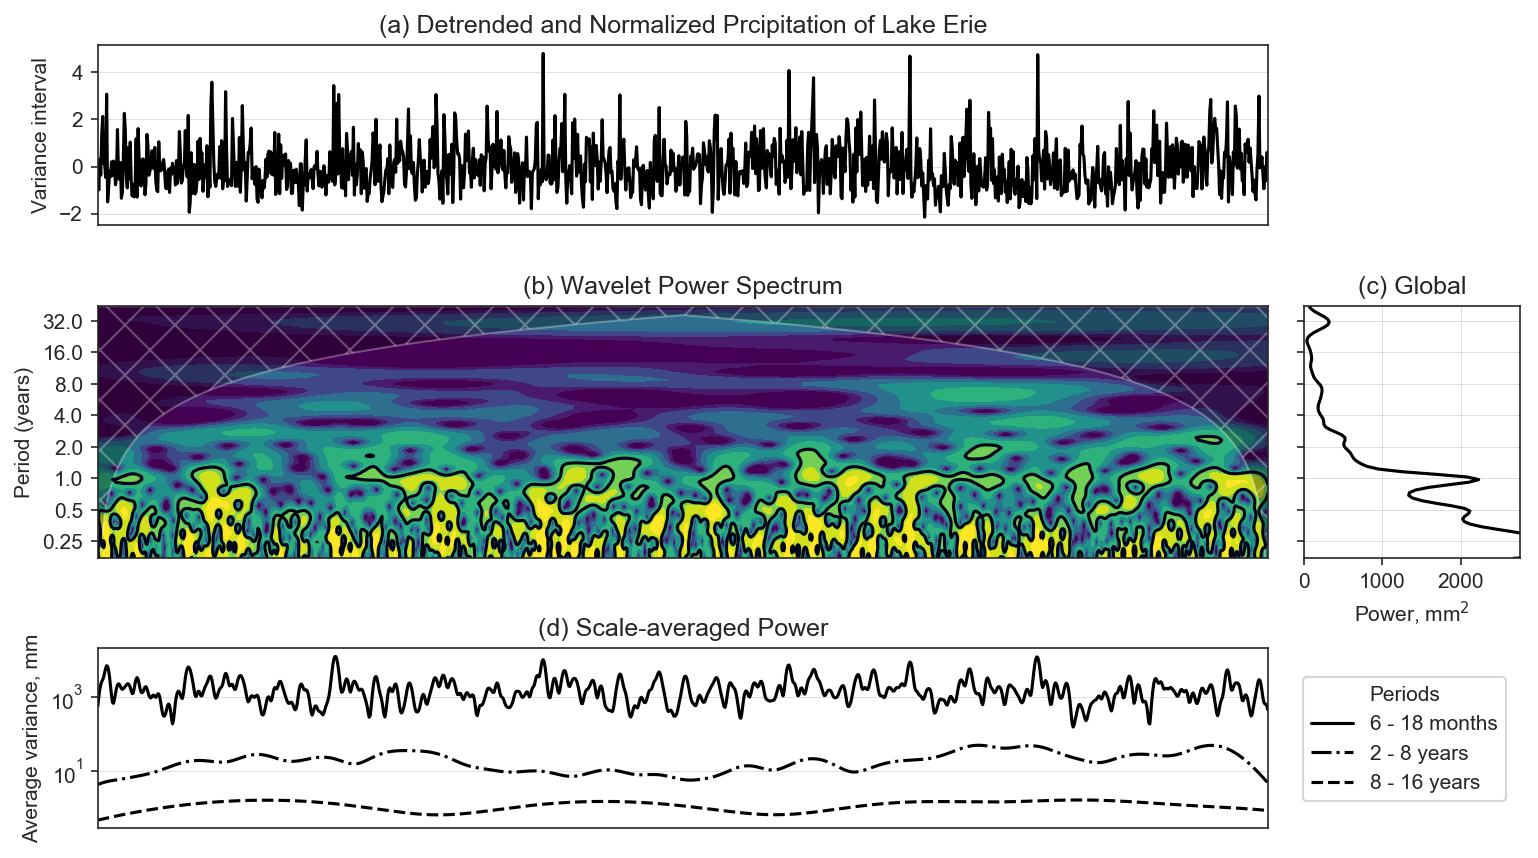

In [69]:
# Prepare the figure
plt.close('all')
plt.ioff()
figprops = dict(figsize=(12, 6), dpi=150)
fig = plt.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
# ax = plt.axes([0.1, 0.8, 0.65, 0.18])
# ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
# ax.plot(t, dat, 'k', linewidth=1.5)
# # ax.set_title('a) {}'.format(title))
# # ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = plt.axes([0.1, 0.38, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
            extend='both', cmap=plt.cm.viridis)
# bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels), colors='k', linewidths=2)
extent = [t.min(), t.max(), 0, max(period)]

bx.contour(t, np.log2(period), np.log2(power), np.log2([2]))

# bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
#            extent=extent)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                           np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('(b) Wavelet Power Spectrum')
bx.set_ylabel('Period (years)')
#
Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                           np.ceil(np.log2(period.max())))
# Yticks = 2 ** np.arange(np.ceil(np.log2(0.25)),
#                            np.ceil(np.log2(32.01)))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)


# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = plt.axes([0.77, 0.38, 0.12, 0.28], sharey=bx)
# cx.plot(glbl_signif, np.log2(period), 'k--')
# cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
# cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',linewidth=1.)
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
cx.set_title('(c) Global')
cx.set_xlabel(r'Power, mm$^2$')
cx.set_xlim([0, glbl_power.max() + 3*var])
# cx.set_xlim([0, 0.5])
cx.set_ylim(np.log2([period.min(), period.max()]))
# cx.set_ylim(np.log2([0.25, 32.01]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
plt.setp(cx.get_yticklabels(), visible=False)
cx.grid(lw=0.3)


# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = plt.axes([0.1, 0.08, 0.65, 0.20], sharex=ax)
# dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.semilogy(t, scale_avg, 'k-', linewidth=1.5, label='6 - 18 months')
dx.semilogy(t, scale_avg_2, 'k-.', linewidth=1.5, label='2 - 8 years')
dx.semilogy(t, scale_avg_3, 'k--', linewidth=1.5, label='8 - 16 years')
dx.set_title('(d) Scale-averaged Power'.format(0.5, 1.5))
# dx.set_xlabel('Time (year)')
dx.legend(loc=(1.03,0.15), title='Periods')
dx.set_ylabel(r'Average variance, {}'.format(units))
ax.set_xlim([t.min(), t.max()])
dx.grid(lw=0.3)

# Fourth sub-plot, the scale averaged wavelet spectrum.
fx = plt.axes([0.1, 0.75, 0.65, 0.20], sharex=ax)
# dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
# fx.plot(t, scale_avg_2, 'k-', linewidth=1.5)
# fx.set_title('{}--{} year scale-averaged power'.format(3, 16))
# fx.set_xlabel('Time (year)')
# fx.set_ylabel(r'Average variance, {}'.format(units))
# # dx.set_ylabel(r'Average variance [{}]'.format(units))
# # fx.set_xlim([t.min(), t.max()])
# fx.grid(lw=0.3)

# ex = plt.axes([0.68, 0.14, 0.35, 0.45])
fx=sns.lineplot(t, dat_norm,ax=fx, c='k')
fx.set_title('(a) Detrended and Normalized Prcipitation of Lake Erie')
fx.set_ylabel(r'Variance interval')
# fx.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
# fx.plot(t, dat, 'k', linewidth=1.5)
fx.grid(lw=0.3)
fx.set_xlim([t.min(), t.max()])
plt.tight_layout()

# fig.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Water Budget/latex_figures/img/freq_analysis_precip.pdf', dpi=fig.dpi)




In [70]:
prec_t, prec_scale_avg  = t, scale_avg 
prec_t, prec_scale_avg_2 = t, scale_avg_2
prec_t, prec_scale_avg_3 = t, scale_avg_3

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


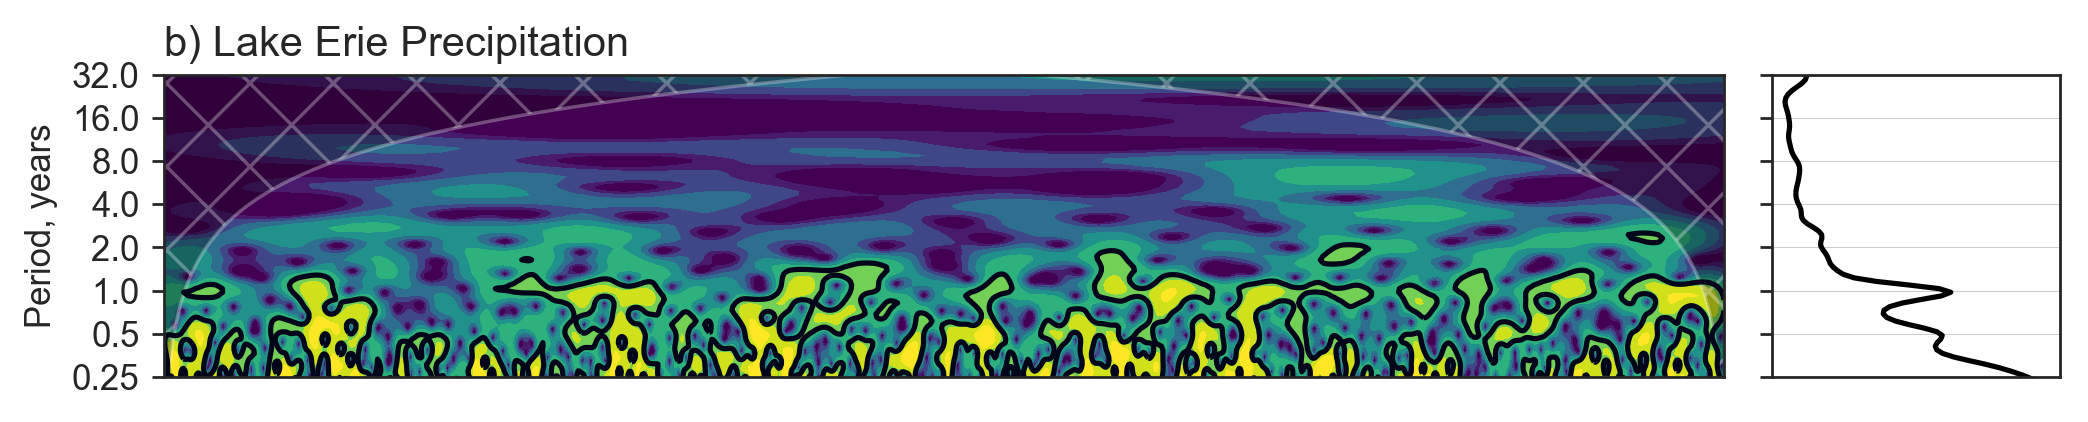

In [72]:
plt.close('all')
plt.ioff()
figprops = dict(figsize=(8*1.2, 1.6*1.2), dpi=250)
fig = plt.figure(**figprops)
bx = plt.axes([0.1, 0.2, 0.65, 0.63], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8,]
bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
            extend='both', cmap=plt.cm.viridis)
# bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels), colors='k', linewidths=2)
extent = [t.min(), t.max(), 0, max(period)]

bx.contour(t, np.log2(period), np.log2(power), np.log2([2]))

# bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
#            extent=extent)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                           np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.text(0,1.1, 'b) Lake Erie Precipitation', horizontalalignment='left', verticalalignment='center', transform=bx.transAxes, fontsize='large')
# bx.set_title('Wavelet Power Spectrum')
bx.set_ylabel('Period, years')
#
# Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
#                            np.ceil(np.log2(period.max())))
Yticks = 2 ** np.arange(np.ceil(np.log2(0.25)),
                           np.ceil(np.log2(32.01)))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)
bx.set_xticks(np.arange(1920,2020,10))
bx.set_xticks([])

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = plt.axes([0.77, 0.2, 0.12, 0.63], sharey=bx)
# cx.plot(glbl_signif, np.log2(period), 'k--')
# cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
# cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',linewidth=1.)
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
# cx.set_title('Global Power')
# cx.set_xlabel(r'Power')
# cx.set_xlim([0, glbl_power.max() + var])
# cx.set_xlim([0, glbl_power.max()/var/10])
cx.set_xticks([])
# cx.set_ylim(np.log2([period.min(), period.max()]))
cx.set_ylim(np.log2([0.25, 32.01]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
plt.setp(cx.get_yticklabels(), visible=False)
cx.grid(lw=0.3)
plt.tight_layout()
# fig.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Water Budget/latex_figures/img/freq_precip_brighter.pdf', dpi=fig.dpi)




# NAO and PDO

In [29]:
NAO = pd.read_excel('../../measurements/Oscillations/nao.xlsx')
NAO = NAO[NAO.Mean>-80]
# PDO = pd.read_excel('../../measurements/Oscillations/pdo.xlsx', sheet_name='Data')

NAO.columns

for c in NAO.columns:
    NAO[c] = pd.to_numeric(NAO[c], errors='coerce')


NAO.head()

Year  January  February  March  April   May  June  July  August  September  \
4  1825    -0.23      0.21   0.33  -0.28  0.13  0.41 -0.92    1.43      -0.95   
5  1826    -3.05      4.87  -0.97   1.78 -1.20  0.83  1.89    2.72      -0.76   
6  1827    -0.45     -3.72   1.83  -0.83  1.20 -0.07  2.02   -3.56      -0.07   
7  1828     1.27      0.37  -0.18   0.04 -1.59 -1.33 -4.40   -2.54      -2.78   
8  1829    -2.48      0.32  -2.54   0.12  1.80 -0.10  0.33    0.77       0.78   

   October  November  December  Mean  
4     1.98      1.06     -1.31  0.16  
5     0.18     -2.41     -0.59  0.27  
6    -3.02     -1.42      2.70 -0.45  
7     0.10     -2.57      3.04 -0.88  
8     0.71     -0.33     -0.43 -0.09

In [30]:
NAO_agg = NAO.groupby('Year').mean()[NAO.columns[1:-1]].stack().reset_index()

NAO_agg['M_n'] = NAO_agg['level_1'].apply(lambda x: datetime.datetime.strptime(x, '%B').month)

NAO_agg['Year_dec']= NAO_agg['Year'] + NAO_agg['M_n']/12

Text(0.5, 0, 'Year')

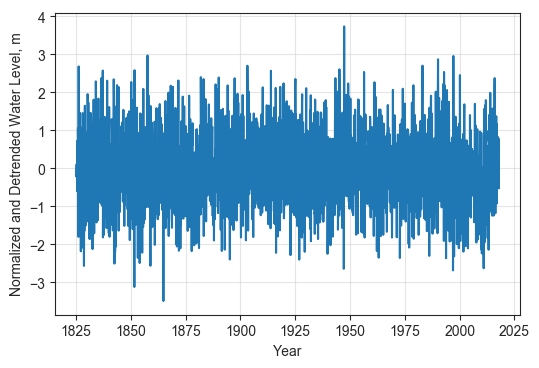

In [31]:
# t = discharge['Year_dec'].values
t = NAO_agg['Year_dec'].values
# t = Niagara_flow['Water Year'].values
t0 = t[0]
dt=1/12
dat =NAO_agg[0]
# dat = Niagara_flow['CFS'].values
N = dat.size

p = np.polyfit(t - t0, dat, 1)
dat_notrend = dat - np.polyval(p, t - t0)
std = dat_notrend.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset

fig,ax=plt.subplots(1,1,figsize=(6,4), dpi=100)
ax=sns.lineplot(t, dat_norm,ax=ax)

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes


# ax.legend(['({}) - {}'.format(selected_stations.index(site)+1, site)], loc=2, fontsize='small')
# ax.legend(['(11) - '+site], loc=2, fontsize='small')
# ax.set_ylim(0,None)
# ax.set_xlim(datetime.datetime(1928,1,1), datetime.datetime(2019,1,1))
ax.grid(alpha=0.5)
ax.set_ylabel("Normalized and Detrended Water Level, m")
ax.set_xlabel("Year")

# axins = zoomed_inset_axes(ax, 8, loc='upper center')
# sns.lineplot(x='Date', y='Discharge, cms', data=discharge, hue='Source', ax=axins,zorder=10)
# axins.set_xlim(datetime.datetime(2010,4,1), datetime.datetime(2010,6,1)) # apply the x-limits
# axins.set_ylim(0, 10) # apply the y-limits
# plt.yticks(visible=False)
# plt.xticks(visible=False)
# from mpl_toolkits.axes_grid1.inset_locator import mark_inset
# mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")




In [32]:
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 8 / dj  # Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

power = (np.abs(wave)) ** 2
fft_power = np.abs(fft) ** 2
period = 1 / freqs

power = power/scales[:, None]

signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = np.ones([1, N]) * signif[:, None]
sig95 = power / sig95

glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

sel = find((period <= 0.5))
Cdelta = mother.cdelta
scale_avg = (scales * np.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)


sel = find((period >= 8/12) & (period <= 14/12))
Cdelta = mother.cdelta
scale_avg_2 = (scales * np.ones((N, 1))).transpose()
scale_avg_2 = power / scale_avg_2  # As in Torrence and Compo (1998) equation 24
scale_avg_2 = var * dj * dt / Cdelta * scale_avg_2[sel, :].sum(axis=0)
scale_avg_signif_2, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

sel = find((period >= 2) & (period <= 8))
Cdelta = mother.cdelta
scale_avg_3 = (scales * np.ones((N, 1))).transpose()
scale_avg_3 = power / scale_avg_3  # As in Torrence and Compo (1998) equation 24
scale_avg_3 = var * dj * dt / Cdelta * scale_avg_3[sel, :].sum(axis=0)
scale_avg_signif_2, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

In [33]:
units = '[-]'

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


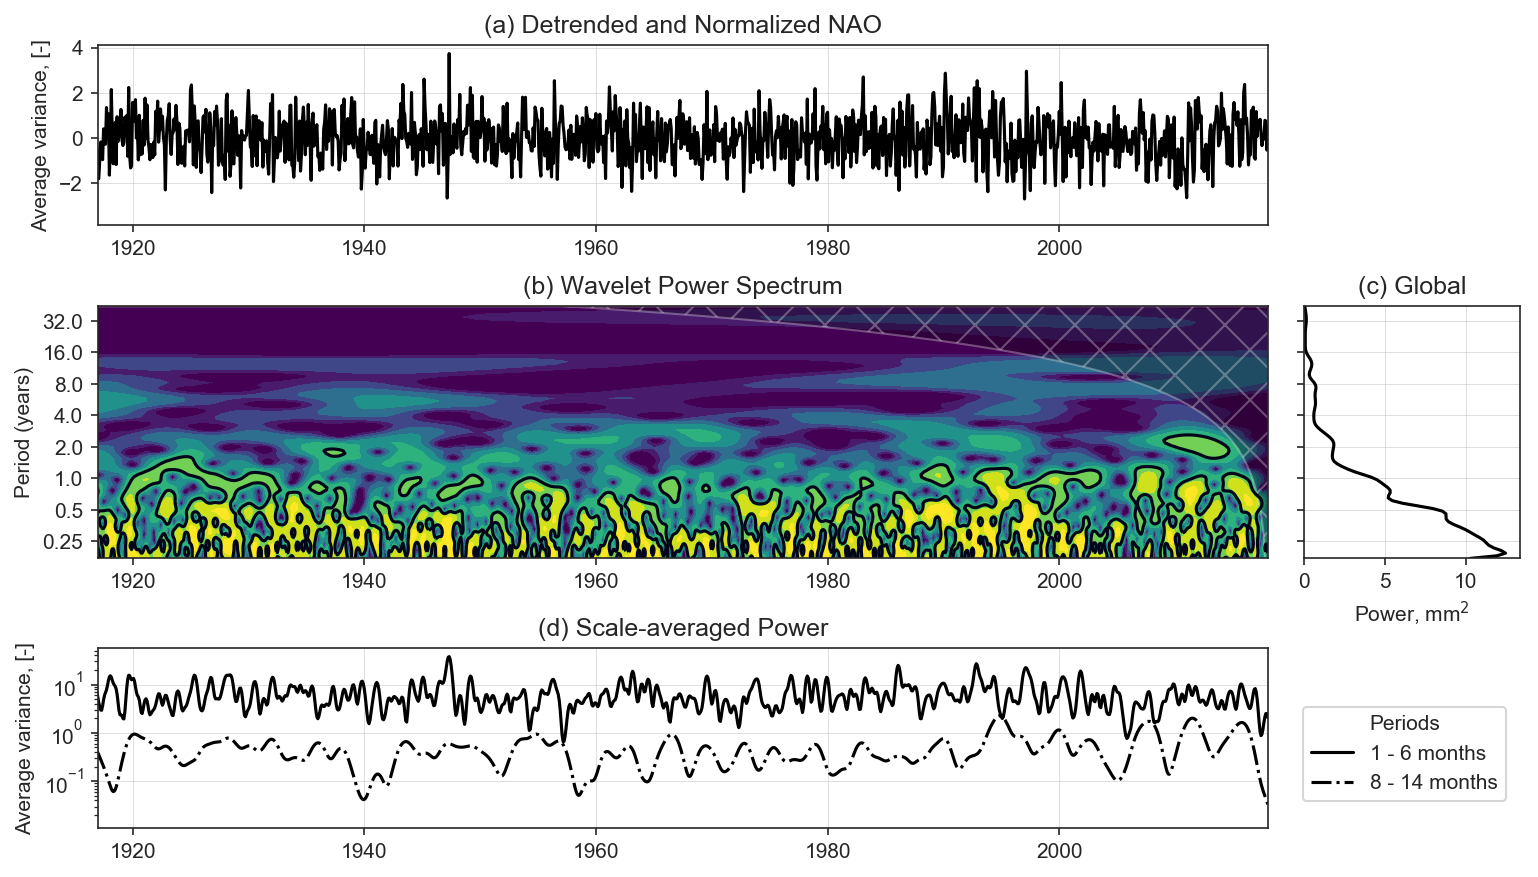

In [34]:
# Prepare the figure
plt.close('all')
plt.ioff()
figprops = dict(figsize=(12, 6), dpi=150)
fig = plt.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
# ax = plt.axes([0.1, 0.8, 0.65, 0.18])
# ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
# ax.plot(t, dat, 'k', linewidth=1.5)
# # ax.set_title('a) {}'.format(title))
# # ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = plt.axes([0.1, 0.38, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
            extend='both', cmap=plt.cm.viridis)
# bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels), colors='k', linewidths=2)
extent = [t.min(), t.max(), 0, max(period)]

bx.contour(t, np.log2(period), np.log2(power), np.log2([2]))

# bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
#            extent=extent)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                           np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('(b) Wavelet Power Spectrum')
bx.set_ylabel('Period (years)')
#
Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                           np.ceil(np.log2(period.max())))
# Yticks = 2 ** np.arange(np.ceil(np.log2(0.25)),
#                            np.ceil(np.log2(32.01)))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)


# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = plt.axes([0.77, 0.38, 0.12, 0.28], sharey=bx)
# cx.plot(glbl_signif, np.log2(period), 'k--')
# cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
# cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',linewidth=1.)
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
cx.set_title('(c) Global')
cx.set_xlabel(r'Power, mm$^2$')
cx.set_xlim([0, glbl_power.max() + 3*var])
# cx.set_xlim([0, 0.5])
cx.set_ylim(np.log2([period.min(), period.max()]))
# cx.set_ylim(np.log2([0.25, 32.01]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
plt.setp(cx.get_yticklabels(), visible=False)
cx.grid(lw=0.3)


# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = plt.axes([0.1, 0.08, 0.65, 0.20], sharex=ax)
# dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.semilogy(t, scale_avg, 'k-', linewidth=1.5, label='1 - 6 months')
dx.semilogy(t, scale_avg_2, 'k-.', linewidth=1.5, label='8 - 14 months')
# dx.semilogy(t, scale_avg_3, 'k--', linewidth=1.5, label='8 - 16 years')
dx.set_title('(d) Scale-averaged Power'.format(0.5, 1.5))
# dx.set_xlabel('Time (year)')
dx.legend(loc=(1.03,0.15), title='Periods')
dx.set_ylabel(r'Average variance, {}'.format(units))
ax.set_xlim([t.min(), t.max()])
dx.grid(lw=0.3)

# Fourth sub-plot, the scale averaged wavelet spectrum.
fx = plt.axes([0.1, 0.75, 0.65, 0.20], sharex=ax)
# dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
# fx.plot(t, scale_avg_2, 'k-', linewidth=1.5)
# fx.set_title('{}--{} year scale-averaged power'.format(3, 16))
# fx.set_xlabel('Time (year)')
# fx.set_ylabel(r'Average variance, {}'.format(units))
# # dx.set_ylabel(r'Average variance [{}]'.format(units))
# # fx.set_xlim([t.min(), t.max()])
# fx.grid(lw=0.3)

# ex = plt.axes([0.68, 0.14, 0.35, 0.45])
fx=sns.lineplot(t, dat_norm,ax=fx, c='k')
fx.set_title('(a) Detrended and Normalized NAO')
fx.set_ylabel(r'Average variance, {}'.format(units))
# fx.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
# fx.plot(t, dat, 'k', linewidth=1.5)
fx.grid(lw=0.3)
fx.set_xlim([t.min(), t.max()])
fx.set_xlim([1917, t.max()])
plt.tight_layout()

# fig.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Water Budget/latex_figures/img/freq_analysis_nao.pdf', dpi=f.dpi)




# PDO

In [35]:
PDO = pd.read_excel('../../measurements/Oscillations/pdo.xlsx', sheet_name='Data')

In [36]:
PDO.head()

YEAR   JAN   FEB   MAR   APR   MAY   JUN   JUL   AUG   SEP   OCT   NOV  \
0     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1  1900.0  0.04  1.32  0.49  0.35  0.77  0.65  0.95  0.14 -0.24  0.23 -0.44   
2  1901.0  0.79 -0.12  0.35  0.61 -0.42 -0.05 -0.60 -1.20 -0.33  0.16 -0.60   
3  1902.0  0.82  1.58  0.48  1.37  1.09  0.52  1.58  1.57  0.44  0.70  0.16   
4  1903.0  0.86 -0.24 -0.22 -0.50  0.43  0.23  0.40  1.01 -0.24  0.18  0.08   

    DEC  
0   NaN  
1  1.19  
2 -0.14  
3 -1.10  
4 -0.03

In [37]:
for c in PDO.columns:
    PDO[c] = pd.to_numeric(PDO[c], errors='coerce')


PDO_agg = PDO.groupby('YEAR').mean()[PDO.columns[1:-1]].stack().reset_index()

PDO_agg['M_n'] = PDO_agg['level_1'].apply(lambda x: datetime.datetime.strptime(x, '%b').month)

PDO_agg['Year_dec']= PDO_agg['YEAR'] + PDO_agg['M_n']/12

Text(0.5, 0, 'Year')

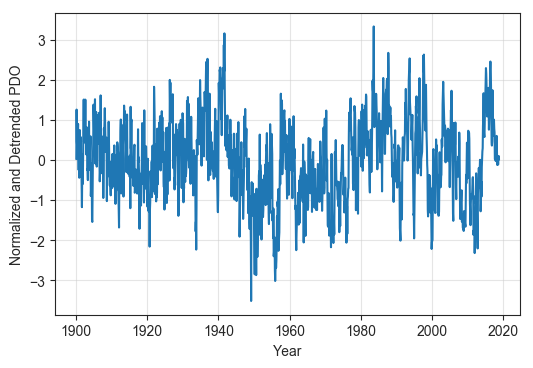

In [73]:
# t = discharge['Year_dec'].values
t = PDO_agg['Year_dec'].values
# t = Niagara_flow['Water Year'].values
t0 = t[0]
dt=1/12
dat =PDO_agg[0]
# dat = Niagara_flow['CFS'].values
N = dat.size

p = np.polyfit(t - t0, dat, 1)
dat_notrend = dat - np.polyval(p, t - t0)
std = dat_notrend.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset

fig,ax=plt.subplots(1,1,figsize=(6,4), dpi=100)
ax=sns.lineplot(t, dat_norm,ax=ax)

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes


# ax.legend(['({}) - {}'.format(selected_stations.index(site)+1, site)], loc=2, fontsize='small')
# ax.legend(['(11) - '+site], loc=2, fontsize='small')
# ax.set_ylim(0,None)
# ax.set_xlim(datetime.datetime(1928,1,1), datetime.datetime(2019,1,1))
ax.grid(alpha=0.5)
ax.set_ylabel("Normalized and Detrended PDO")
ax.set_xlabel("Year")

# axins = zoomed_inset_axes(ax, 8, loc='upper center')
# sns.lineplot(x='Date', y='Discharge, cms', data=discharge, hue='Source', ax=axins,zorder=10)
# axins.set_xlim(datetime.datetime(2010,4,1), datetime.datetime(2010,6,1)) # apply the x-limits
# axins.set_ylim(0, 10) # apply the y-limits
# plt.yticks(visible=False)
# plt.xticks(visible=False)
# from mpl_toolkits.axes_grid1.inset_locator import mark_inset
# mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")




In [74]:
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 8 / dj  # Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

power = (np.abs(wave)) ** 2
fft_power = np.abs(fft) ** 2
period = 1 / freqs

power = power/scales[:, None]

signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = np.ones([1, N]) * signif[:, None]
sig95 = power / sig95

glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

sel = find((period <= 0.5))
Cdelta = mother.cdelta
scale_avg = (scales * np.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)


sel = find((period >= 8/12) & (period <= 14/12))
Cdelta = mother.cdelta
scale_avg_2 = (scales * np.ones((N, 1))).transpose()
scale_avg_2 = power / scale_avg_2  # As in Torrence and Compo (1998) equation 24
scale_avg_2 = var * dj * dt / Cdelta * scale_avg_2[sel, :].sum(axis=0)
scale_avg_signif_2, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

sel = find((period >= 2) & (period <= 8))
Cdelta = mother.cdelta
scale_avg_3 = (scales * np.ones((N, 1))).transpose()
scale_avg_3 = power / scale_avg_3  # As in Torrence and Compo (1998) equation 24
scale_avg_3 = var * dj * dt / Cdelta * scale_avg_3[sel, :].sum(axis=0)
scale_avg_signif_2, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


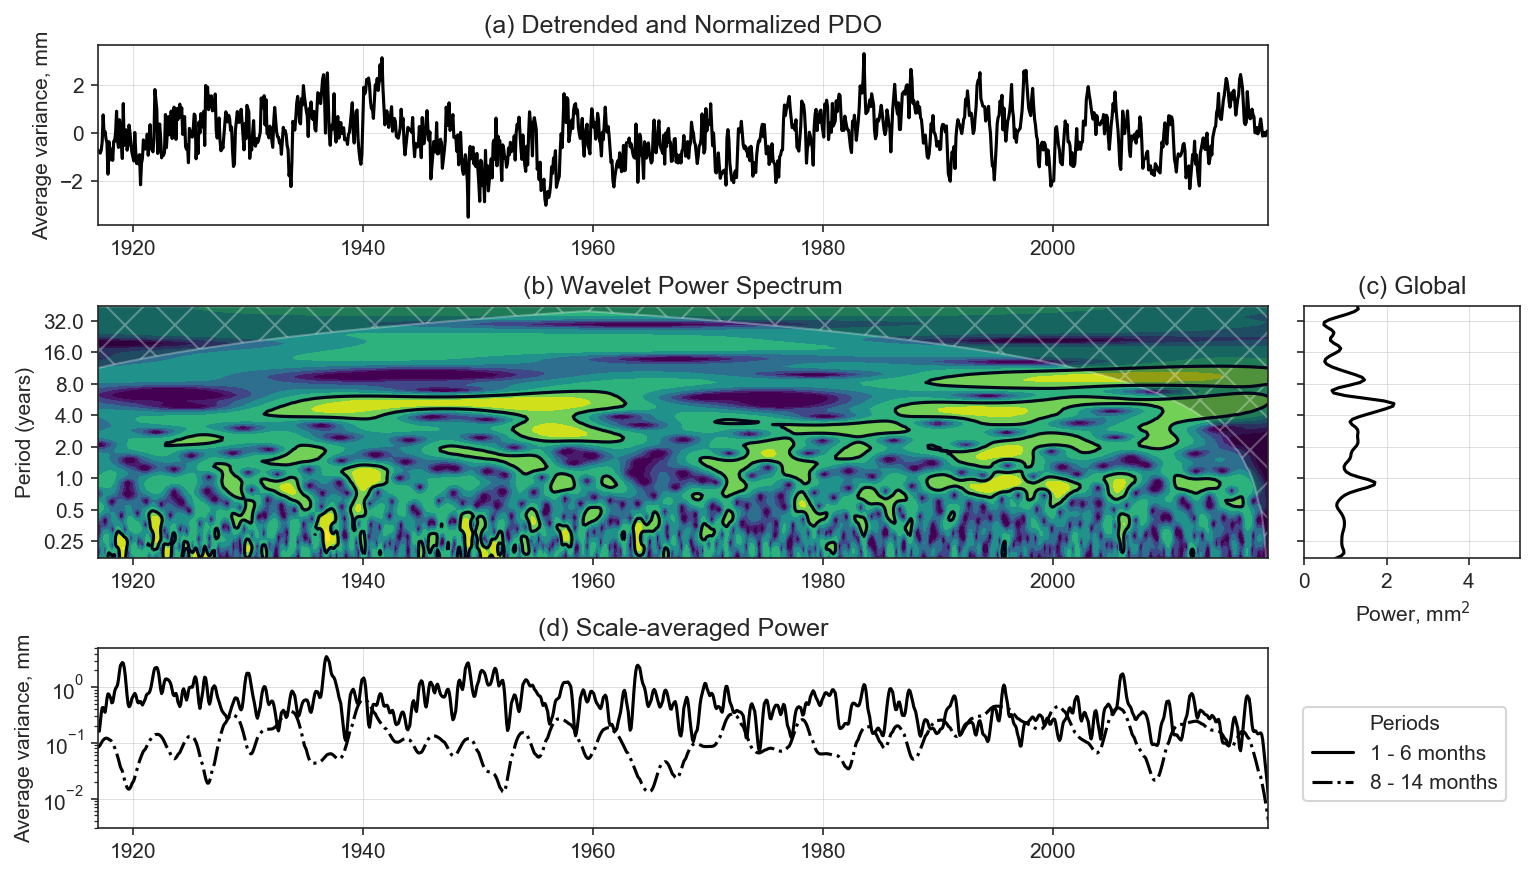

In [75]:
# Prepare the figure
plt.close('all')
plt.ioff()
figprops = dict(figsize=(12, 6), dpi=150)
fig = plt.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
# ax = plt.axes([0.1, 0.8, 0.65, 0.18])
# ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
# ax.plot(t, dat, 'k', linewidth=1.5)
# # ax.set_title('a) {}'.format(title))
# # ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = plt.axes([0.1, 0.38, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
            extend='both', cmap=plt.cm.viridis)
# bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels), colors='k', linewidths=2)
extent = [t.min(), t.max(), 0, max(period)]

bx.contour(t, np.log2(period), np.log2(power), np.log2([2]))

# bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
#            extent=extent)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                           np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('(b) Wavelet Power Spectrum')
bx.set_ylabel('Period (years)')
#
Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                           np.ceil(np.log2(period.max())))
# Yticks = 2 ** np.arange(np.ceil(np.log2(0.25)),
#                            np.ceil(np.log2(32.01)))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)


# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = plt.axes([0.77, 0.38, 0.12, 0.28], sharey=bx)
# cx.plot(glbl_signif, np.log2(period), 'k--')
# cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
# cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',linewidth=1.)
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
cx.set_title('(c) Global')
cx.set_xlabel(r'Power, mm$^2$')
cx.set_xlim([0, glbl_power.max() + 3*var])
# cx.set_xlim([0, 0.5])
cx.set_ylim(np.log2([period.min(), period.max()]))
# cx.set_ylim(np.log2([0.25, 32.01]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
plt.setp(cx.get_yticklabels(), visible=False)
cx.grid(lw=0.3)


# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = plt.axes([0.1, 0.08, 0.65, 0.20], sharex=ax)
# dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.semilogy(t, scale_avg, 'k-', linewidth=1.5, label='1 - 6 months')
dx.semilogy(t, scale_avg_2, 'k-.', linewidth=1.5, label='8 - 14 months')
# dx.semilogy(t, scale_avg_3, 'k--', linewidth=1.5, label='8 - 16 years')
dx.set_title('(d) Scale-averaged Power'.format(0.5, 1.5))
# dx.set_xlabel('Time (year)')
dx.legend(loc=(1.03,0.15), title='Periods')
dx.set_ylabel(r'Average variance, {}'.format(units))
ax.set_xlim([t.min(), t.max()])
dx.grid(lw=0.3)

# Fourth sub-plot, the scale averaged wavelet spectrum.
fx = plt.axes([0.1, 0.75, 0.65, 0.20], sharex=ax)
# dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
# fx.plot(t, scale_avg_2, 'k-', linewidth=1.5)
# fx.set_title('{}--{} year scale-averaged power'.format(3, 16))
# fx.set_xlabel('Time (year)')
# fx.set_ylabel(r'Average variance, {}'.format(units))
# # dx.set_ylabel(r'Average variance [{}]'.format(units))
# # fx.set_xlim([t.min(), t.max()])
# fx.grid(lw=0.3)

# ex = plt.axes([0.68, 0.14, 0.35, 0.45])
fx=sns.lineplot(t, dat_norm,ax=fx, c='k')
fx.set_title('(a) Detrended and Normalized PDO')
fx.set_ylabel(r'Average variance, {}'.format(units))
# fx.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
# fx.plot(t, dat, 'k', linewidth=1.5)
fx.grid(lw=0.3)
fx.set_xlim([t.min(), t.max()])
fx.set_xlim([1917, t.max()])
plt.tight_layout()

# fig.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Water Budget/latex_figures/img/freq_analysis_pdo.pdf', dpi=f.dpi)




/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


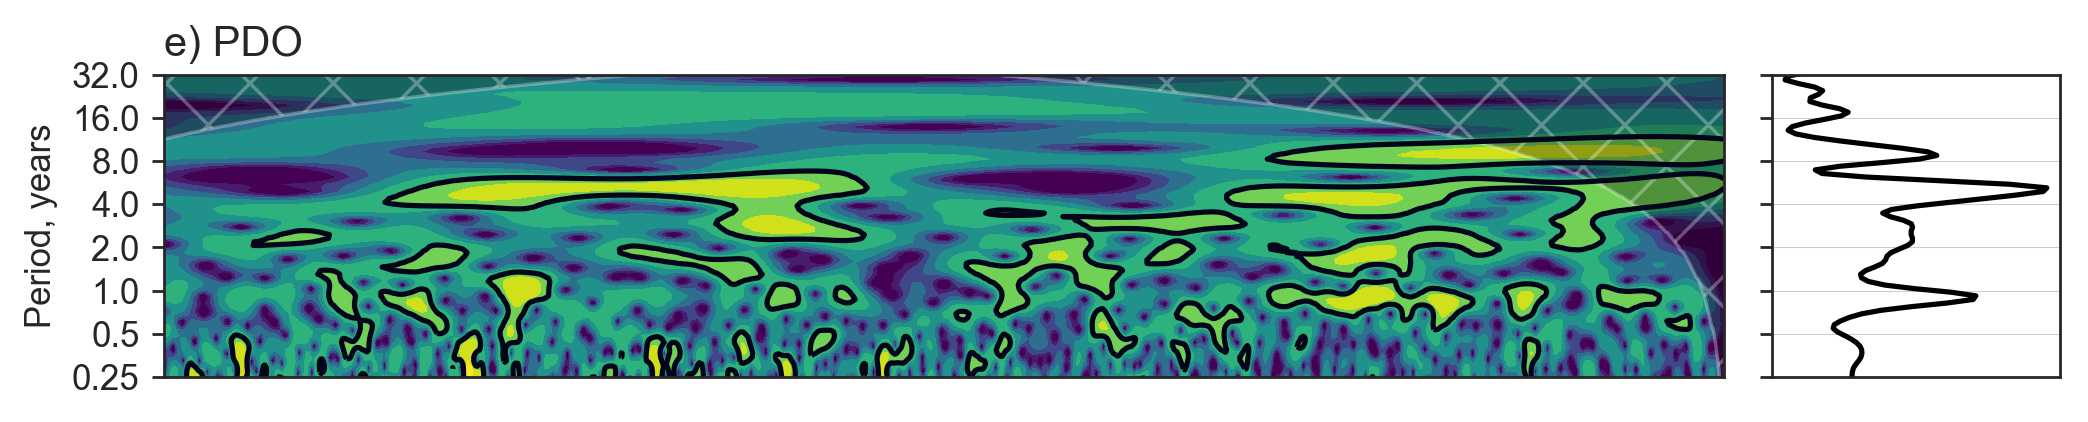

In [77]:
plt.close('all')
plt.ioff()
figprops = dict(figsize=(8*1.2, 1.6*1.2), dpi=250)
fig = plt.figure(**figprops)
bx = plt.axes([0.1, 0.2, 0.65, 0.63], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8,]
bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
            extend='both', cmap=plt.cm.viridis)
# bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels), colors='k', linewidths=2)
extent = [t.min(), t.max(), 0, max(period)]

bx.contour(t, np.log2(period), np.log2(power), np.log2([2]))

# bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
#            extent=extent)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                           np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.text(0,1.1, 'e) PDO', horizontalalignment='left', verticalalignment='center', transform=bx.transAxes, fontsize='large')
# bx.set_title('Wavelet Power Spectrum')
bx.set_ylabel('Period, years')
#
# Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
#                            np.ceil(np.log2(period.max())))
Yticks = 2 ** np.arange(np.ceil(np.log2(0.25)),
                           np.ceil(np.log2(32.01)))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)
bx.set_xticks(np.arange(1920,2020,10))
bx.set_xticks([])

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = plt.axes([0.77, 0.2, 0.12, 0.63], sharey=bx)
# cx.plot(glbl_signif, np.log2(period), 'k--')
# cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
# cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',linewidth=1.)
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
# cx.set_title('Global Power')
# cx.set_xlabel(r'Power')
# cx.set_xlim([0, glbl_power.max() + var])
# cx.set_xlim([0, glbl_power.max()/var/10])
cx.set_xticks([])
# cx.set_ylim(np.log2([period.min(), period.max()]))
cx.set_ylim(np.log2([0.25, 32.01]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
plt.setp(cx.get_yticklabels(), visible=False)
cx.grid(lw=0.3)
plt.tight_layout()
# fig.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Water Budget/latex_figures/img/freq_pdo.pdf', dpi=fig.dpi)




# SOI

In [55]:
SOI = pd.read_csv('../../measurements/Oscillations/soi.csv')
SOI = SOI[SOI.Mean>-80]


for c in SOI.columns:
    SOI[c] = pd.to_numeric(SOI[c], errors='coerce')


SOI.head()

Year  January  February  March  April   May  June  July  August  September  \
0  1866    -0.62     -0.12  -0.62  -0.65  0.04 -0.82 -0.34    0.36      -0.18   
1  1867     0.09     -0.01  -0.09   0.83  0.50 -0.48  0.44    0.34       0.12   
2  1868    -0.16     -0.34  -1.56   0.30 -1.34 -2.20 -0.40   -1.41      -1.23   
3  1869    -1.90     -0.26  -0.59   2.12  1.40  1.53  1.42    0.94       0.12   
4  1870     1.06      0.18  -0.75   0.47 -0.11 -1.10  0.17    0.98      -0.00   

   October  November  December  Mean  
0     0.07      1.10     -0.16 -0.16  
1    -0.56     -0.65     -0.89 -0.03  
2    -1.24     -1.49      0.52 -0.88  
3     0.85      0.56      0.42  0.55  
4    -0.58     -0.86     -1.29 -0.15

In [56]:
SOI_agg = SOI.groupby('Year').mean()[SOI.columns[1:-1]].stack().reset_index()
SOI_agg['M_n'] = SOI_agg['level_1'].apply(lambda x: datetime.datetime.strptime(x, '%B').month)
SOI_agg['Year_dec']= SOI_agg['Year'] + SOI_agg['M_n']/12

Text(0.5, 0, 'Year')

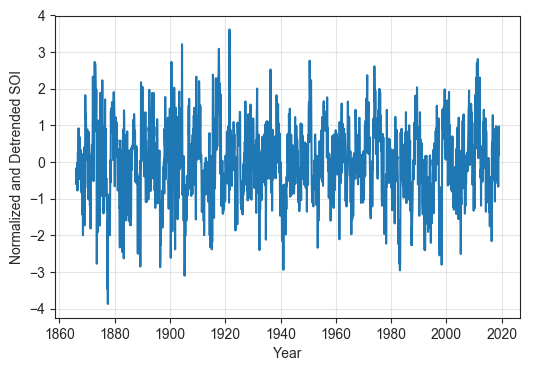

In [57]:
# t = discharge['Year_dec'].values
t = SOI_agg['Year_dec'].values
# t = Niagara_flow['Water Year'].values
t0 = t[0]
dt=1/12
dat =SOI_agg[0]
# dat = Niagara_flow['CFS'].values
N = dat.size

p = np.polyfit(t - t0, dat, 1)
dat_notrend = dat - np.polyval(p, t - t0)
std = dat_notrend.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset

fig,ax=plt.subplots(1,1,figsize=(6,4), dpi=100)
ax=sns.lineplot(t, dat_norm,ax=ax)

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes


# ax.legend(['({}) - {}'.format(selected_stations.index(site)+1, site)], loc=2, fontsize='small')
# ax.legend(['(11) - '+site], loc=2, fontsize='small')
# ax.set_ylim(0,None)
# ax.set_xlim(datetime.datetime(1928,1,1), datetime.datetime(2019,1,1))
ax.grid(alpha=0.5)
ax.set_ylabel("Normalized and Detrended SOI")
ax.set_xlabel("Year")

# axins = zoomed_inset_axes(ax, 8, loc='upper center')
# sns.lineplot(x='Date', y='Discharge, cms', data=discharge, hue='Source', ax=axins,zorder=10)
# axins.set_xlim(datetime.datetime(2010,4,1), datetime.datetime(2010,6,1)) # apply the x-limits
# axins.set_ylim(0, 10) # apply the y-limits
# plt.yticks(visible=False)
# plt.xticks(visible=False)
# from mpl_toolkits.axes_grid1.inset_locator import mark_inset
# mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")




In [58]:
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 8 / dj  # Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

power = (np.abs(wave)) ** 2
fft_power = np.abs(fft) ** 2
period = 1 / freqs

power = power/scales[:, None]

signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = np.ones([1, N]) * signif[:, None]
sig95 = power / sig95

glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

sel = find((period >= 0.5) & (period <= 1.5))
Cdelta = mother.cdelta
scale_avg = (scales * np.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)


sel = find((period >= 2) & (period <= 8))
Cdelta = mother.cdelta
scale_avg_2 = (scales * np.ones((N, 1))).transpose()
scale_avg_2 = power / scale_avg_2  # As in Torrence and Compo (1998) equation 24
scale_avg_2 = var * dj * dt / Cdelta * scale_avg_2[sel, :].sum(axis=0)
scale_avg_signif_2, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

sel = find((period >= 8) & (period <= 16))
Cdelta = mother.cdelta
scale_avg_3 = (scales * np.ones((N, 1))).transpose()
scale_avg_3 = power / scale_avg_3  # As in Torrence and Compo (1998) equation 24
scale_avg_3 = var * dj * dt / Cdelta * scale_avg_3[sel, :].sum(axis=0)
scale_avg_signif_2, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

In [59]:
units = '[-]'

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


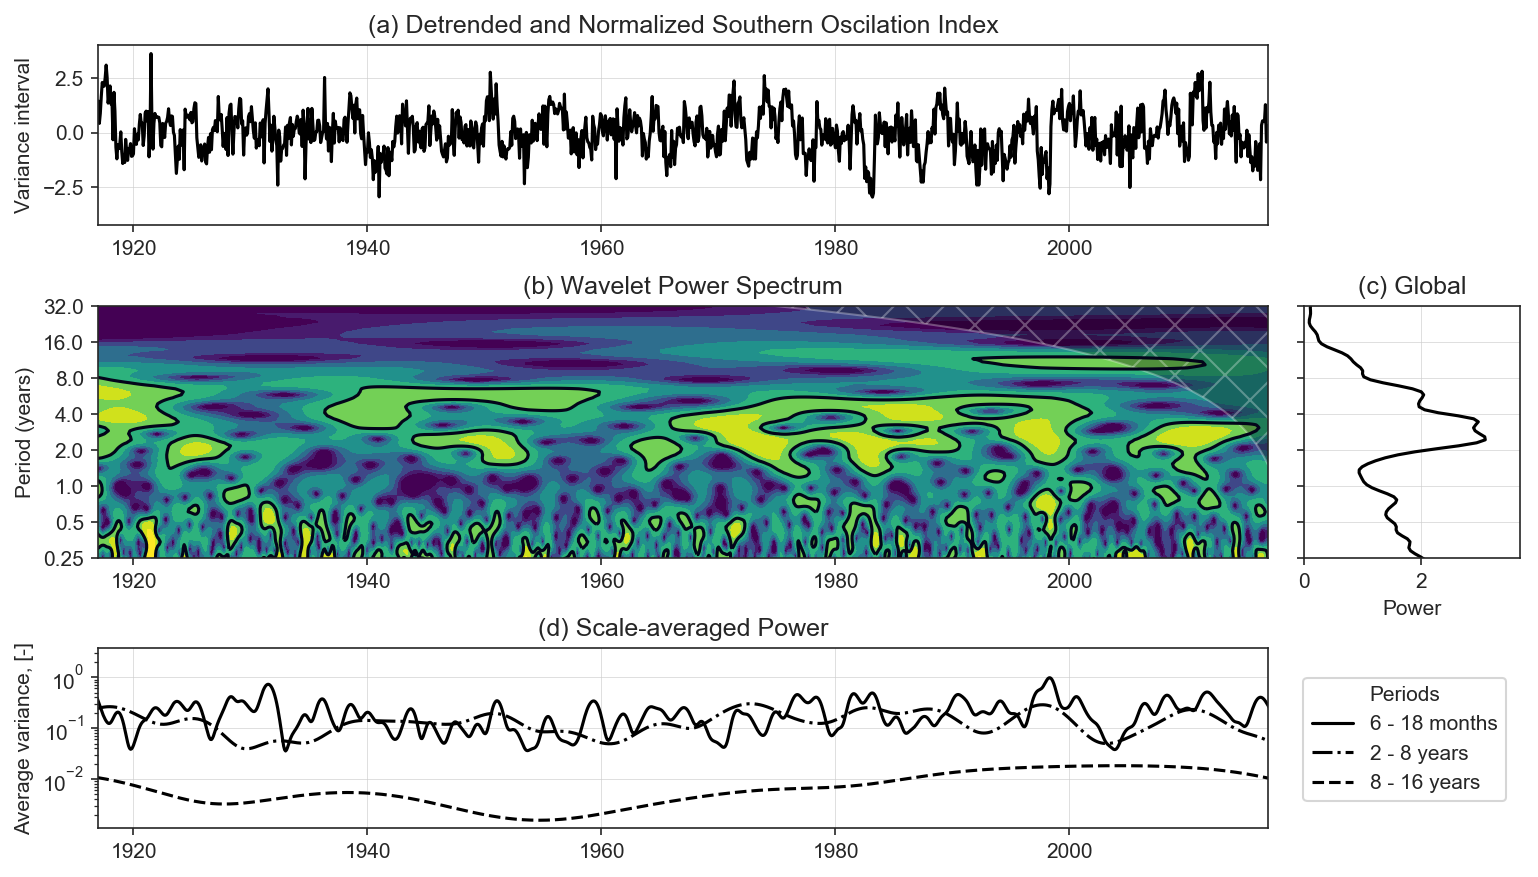

In [60]:
# Prepare the figure
plt.close('all')
plt.ioff()
figprops = dict(figsize=(12, 6), dpi=150)
fig = plt.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
# ax = plt.axes([0.1, 0.8, 0.65, 0.18])
# ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
# ax.plot(t, dat, 'k', linewidth=1.5)
# # ax.set_title('a) {}'.format(title))
# # ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = plt.axes([0.1, 0.38, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
            extend='both', cmap=plt.cm.viridis)
# bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels), colors='k', linewidths=2)
extent = [t.min(), t.max(), 0, max(period)]

bx.contour(t, np.log2(period), np.log2(power), np.log2([2]))

# bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
#            extent=extent)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                           np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('(b) Wavelet Power Spectrum')
bx.set_ylabel('Period (years)')
#
# Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
#                            np.ceil(np.log2(period.max())))
Yticks = 2 ** np.arange(np.ceil(np.log2(0.25)),
                           np.ceil(np.log2(32.01)))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)


# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = plt.axes([0.77, 0.38, 0.12, 0.28], sharey=bx)
# cx.plot(glbl_signif, np.log2(period), 'k--')
# cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
# cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',linewidth=1.)
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
cx.set_title('(c) Global')
cx.set_xlabel(r'Power')
cx.set_xlim([0, glbl_power.max() + var])
# cx.set_xlim([0, 0.5])
# cx.set_ylim(np.log2([period.min(), period.max()]))
cx.set_ylim(np.log2([0.25, 32.01]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
plt.setp(cx.get_yticklabels(), visible=False)
cx.grid(lw=0.3)


# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = plt.axes([0.1, 0.08, 0.65, 0.20], sharex=ax)
# dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.semilogy(t, scale_avg, 'k-', linewidth=1.5, label='6 - 18 months')
dx.semilogy(t, scale_avg_2, 'k-.', linewidth=1.5, label='2 - 8 years')
dx.semilogy(t, scale_avg_3, 'k--', linewidth=1.5, label='8 - 16 years')
dx.set_title('(d) Scale-averaged Power'.format(0.5, 1.5))
# dx.set_xlabel('Time (year)')
dx.legend(loc=(1.03,0.15), title='Periods')
dx.set_ylabel(r'Average variance, {}'.format(units))
ax.set_xlim([t.min(), t.max()])
dx.grid(lw=0.3)

# Fourth sub-plot, the scale averaged wavelet spectrum.
fx = plt.axes([0.1, 0.75, 0.65, 0.20], sharex=ax)
# dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
# fx.plot(t, scale_avg_2, 'k-', linewidth=1.5)
# fx.set_title('{}--{} year scale-averaged power'.format(3, 16))
# fx.set_xlabel('Time (year)')
# fx.set_ylabel(r'Average variance, {}'.format(units))
# # dx.set_ylabel(r'Average variance [{}]'.format(units))
# # fx.set_xlim([t.min(), t.max()])
# fx.grid(lw=0.3)

# ex = plt.axes([0.68, 0.14, 0.35, 0.45])
fx=sns.lineplot(t, dat_norm,ax=fx, c='k')
fx.set_title('(a) Detrended and Normalized Southern Oscilation Index')
fx.set_ylabel(r'Variance interval')
# fx.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
# fx.plot(t, dat, 'k', linewidth=1.5)
fx.grid(lw=0.3)
fx.set_xlim([t.min(), t.max()])
fx.set_xlim([1917, 2017])
plt.tight_layout()

# fig.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Water Budget/latex_figures/img/freq_analysis_soi.pdf', dpi=fig.dpi)




/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


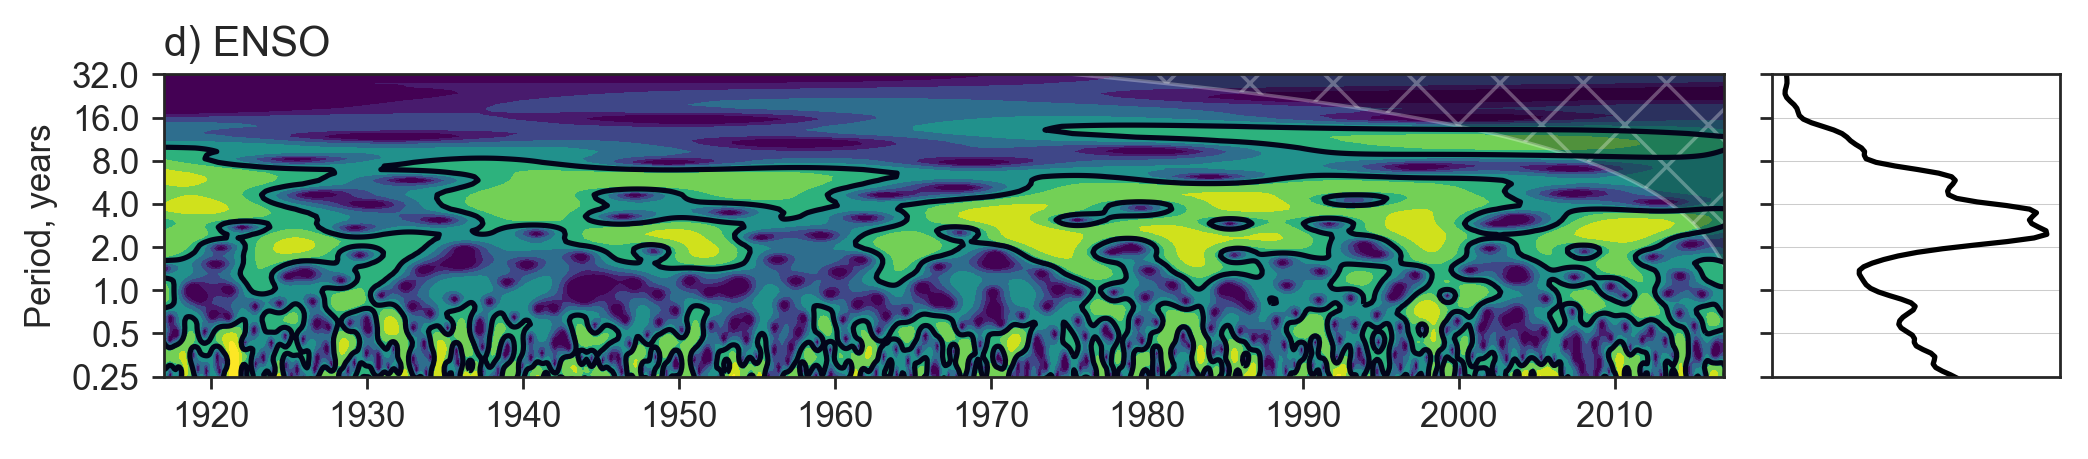

In [61]:
plt.close('all')
plt.ioff()
figprops = dict(figsize=(8*1.2, 1.6*1.2), dpi=250)
fig = plt.figure(**figprops)
bx = plt.axes([0.1, 0.2, 0.65, 0.63], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, ]
bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
            extend='both', cmap=plt.cm.viridis)
# bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels), colors='k', linewidths=2)
extent = [t.min(), t.max(), 0, max(period)]

bx.contour(t, np.log2(period), np.log2(power), np.log2([1]))

# bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
#            extent=extent)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                           np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.text(0,1.1, 'd) ENSO', horizontalalignment='left', verticalalignment='center', transform=bx.transAxes, fontsize='large')
# bx.set_title('Wavelet Power Spectrum')
bx.set_ylabel('Period, years')
#
# Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
#                            np.ceil(np.log2(period.max())))
Yticks = 2 ** np.arange(np.ceil(np.log2(0.25)),
                           np.ceil(np.log2(32.01)))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)
bx.set_xticks(np.arange(1920,2020,10))

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = plt.axes([0.77, 0.2, 0.12, 0.63], sharey=bx)
# cx.plot(glbl_signif, np.log2(period), 'k--')
# cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
# cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',linewidth=1.)
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
# cx.set_title('Global Power')
# cx.set_xlabel(r'Power')
# cx.set_xlim([0, glbl_power.max() + var])
# cx.set_xlim([0, glbl_power.max()/var/10])
cx.set_xticks([])
# cx.set_ylim(np.log2([period.min(), period.max()]))
cx.set_ylim(np.log2([0.25, 32.01]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
plt.setp(cx.get_yticklabels(), visible=False)
cx.grid(lw=0.3)
plt.tight_layout()
# fig.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Water Budget/latex_figures/img/freq_soi.pdf', dpi=fig.dpi)




# El Nino 4 (strong indicator of precipitation and warmer winter)

In [62]:
nino4 = pd.read_csv('../../measurements/Oscillations/nino4.csv', skiprows=8)
# nino4 = nino4[nino4.Mean>-80]


for c in nino4.columns:
    nino4[c] = pd.to_numeric(nino4[c], errors='coerce')


nino4.head()

nino4_agg = nino4.groupby('Year').mean()[nino4.columns[1:]].stack().reset_index()
nino4_agg['M_n'] = nino4_agg['level_1'].apply(lambda x: datetime.datetime.strptime(x, '%B').month)
nino4_agg['Year_dec']= nino4_agg['Year'] + nino4_agg['M_n']/12

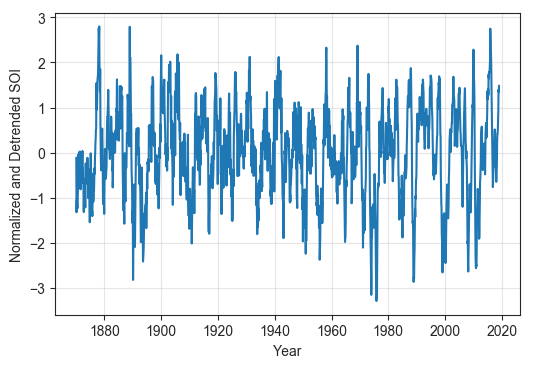

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


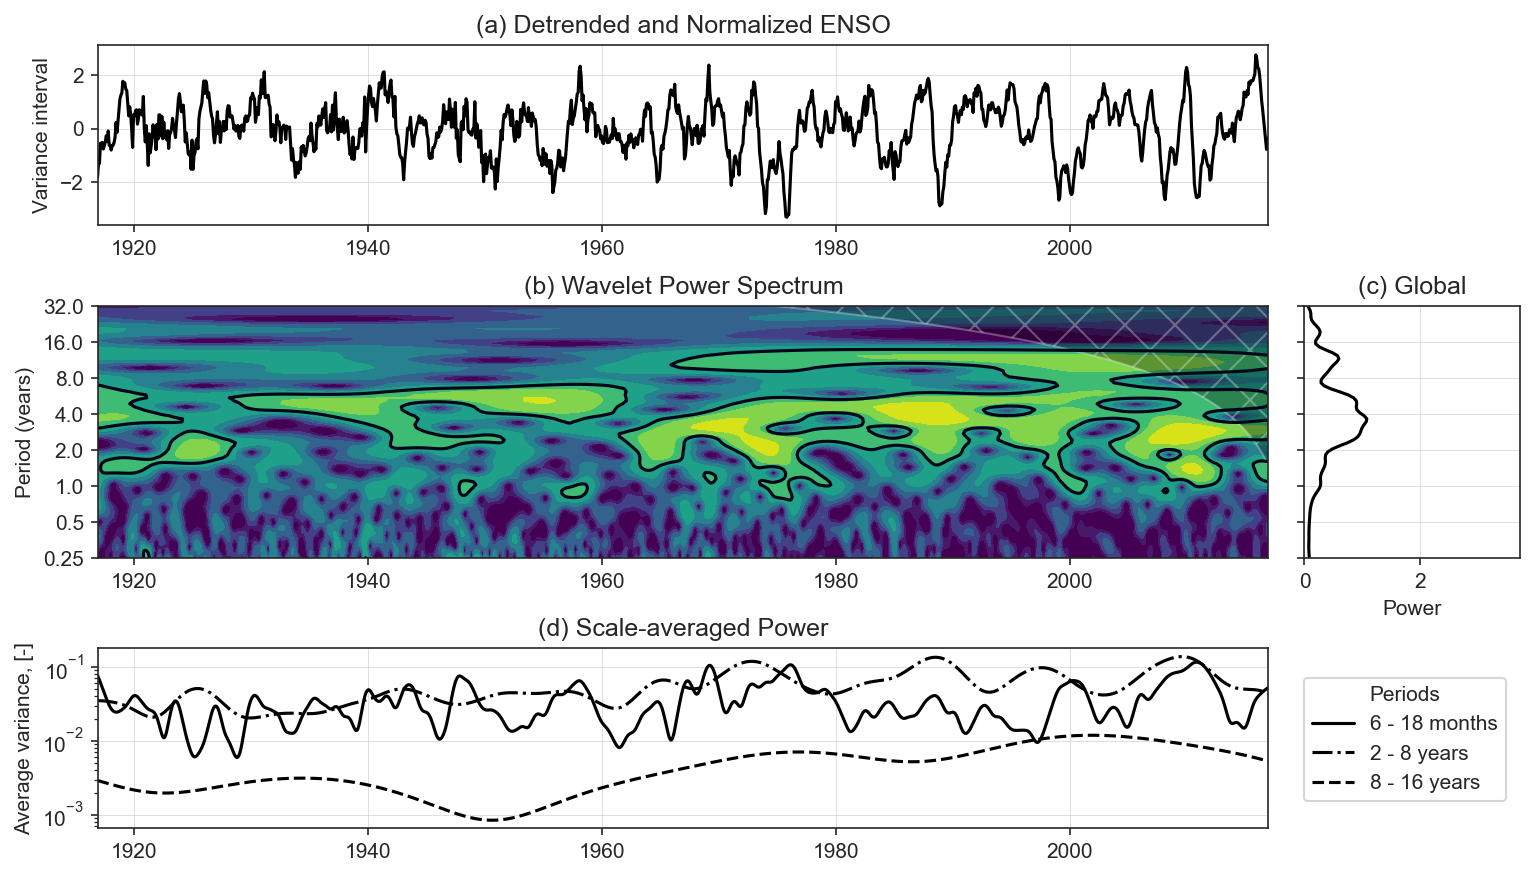

In [143]:
# t = discharge['Year_dec'].values
t = nino4_agg['Year_dec'].values
# t = Niagara_flow['Water Year'].values
t0 = t[0]
dt=1/12
dat =nino4_agg[0]
# dat = Niagara_flow['CFS'].values
N = dat.size

p = np.polyfit(t - t0, dat, 1)
dat_notrend = dat - np.polyval(p, t - t0)
std = dat_notrend.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset

fig,ax=plt.subplots(1,1,figsize=(6,4), dpi=100)
ax=sns.lineplot(t, dat_norm,ax=ax)

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes


# ax.legend(['({}) - {}'.format(selected_stations.index(site)+1, site)], loc=2, fontsize='small')
# ax.legend(['(11) - '+site], loc=2, fontsize='small')
# ax.set_ylim(0,None)
# ax.set_xlim(datetime.datetime(1928,1,1), datetime.datetime(2019,1,1))
ax.grid(alpha=0.5)
ax.set_ylabel("Normalized and Detrended SOI")
ax.set_xlabel("Year")

# axins = zoomed_inset_axes(ax, 8, loc='upper center')
# sns.lineplot(x='Date', y='Discharge, cms', data=discharge, hue='Source', ax=axins,zorder=10)
# axins.set_xlim(datetime.datetime(2010,4,1), datetime.datetime(2010,6,1)) # apply the x-limits
# axins.set_ylim(0, 10) # apply the y-limits
# plt.yticks(visible=False)
# plt.xticks(visible=False)
# from mpl_toolkits.axes_grid1.inset_locator import mark_inset
# mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")


plt.show()

mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 1/12 years = 2 months
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 8 / dj  # Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

power = (np.abs(wave)) ** 2
fft_power = np.abs(fft) ** 2
period = 1 / freqs

power = power/scales[:, None]

signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = np.ones([1, N]) * signif[:, None]
sig95 = power / sig95

glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

sel = find((period >= 0.5) & (period <= 1.5))
Cdelta = mother.cdelta
scale_avg = (scales * np.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)


sel = find((period >= 2) & (period <= 16))
Cdelta = mother.cdelta
scale_avg_2 = (scales * np.ones((N, 1))).transpose()
scale_avg_2 = power / scale_avg_2  # As in Torrence and Compo (1998) equation 24
scale_avg_2 = var * dj * dt / Cdelta * scale_avg_2[sel, :].sum(axis=0)
scale_avg_signif_2, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

sel = find((period >= 8) & (period <= 16))
Cdelta = mother.cdelta
scale_avg_3 = (scales * np.ones((N, 1))).transpose()
scale_avg_3 = power / scale_avg_3  # As in Torrence and Compo (1998) equation 24
scale_avg_3 = var * dj * dt / Cdelta * scale_avg_3[sel, :].sum(axis=0)
scale_avg_signif_2, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

# Prepare the figure
plt.close('all')
plt.ioff()
figprops = dict(figsize=(12, 6), dpi=150)
fig = plt.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
# ax = plt.axes([0.1, 0.8, 0.65, 0.18])
# ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
# ax.plot(t, dat, 'k', linewidth=1.5)
# # ax.set_title('a) {}'.format(title))
# # ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = plt.axes([0.1, 0.38, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
            extend='both', cmap=plt.cm.viridis)
# bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels), colors='k', linewidths=2)
extent = [t.min(), t.max(), 0, max(period)]

bx.contour(t, np.log2(period), np.log2(power), np.log2([2]))

# bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
#            extent=extent)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                           np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('(b) Wavelet Power Spectrum')
bx.set_ylabel('Period (years)')
#
# Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
#                            np.ceil(np.log2(period.max())))
Yticks = 2 ** np.arange(np.ceil(np.log2(0.25)),
                           np.ceil(np.log2(32.01)))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)


# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = plt.axes([0.77, 0.38, 0.12, 0.28], sharey=bx)
# cx.plot(glbl_signif, np.log2(period), 'k--')
# cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
# cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',linewidth=1.)
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
cx.set_title('(c) Global')
cx.set_xlabel(r'Power')
cx.set_xlim([0, glbl_power.max() + var])
# cx.set_xlim([0, 0.5])
# cx.set_ylim(np.log2([period.min(), period.max()]))
cx.set_ylim(np.log2([0.25, 32.01]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
plt.setp(cx.get_yticklabels(), visible=False)
cx.grid(lw=0.3)


# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = plt.axes([0.1, 0.08, 0.65, 0.20], sharex=ax)
# dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.semilogy(t, scale_avg, 'k-', linewidth=1.5, label='6 - 18 months')
dx.semilogy(t, scale_avg_2, 'k-.', linewidth=1.5, label='2 - 8 years')
dx.semilogy(t, scale_avg_3, 'k--', linewidth=1.5, label='8 - 16 years')
dx.set_title('(d) Scale-averaged Power'.format(0.5, 1.5))
# dx.set_xlabel('Time (year)')
dx.legend(loc=(1.03,0.15), title='Periods')
dx.set_ylabel(r'Average variance, {}'.format(units))
ax.set_xlim([t.min(), t.max()])
dx.grid(lw=0.3)

# Fourth sub-plot, the scale averaged wavelet spectrum.
fx = plt.axes([0.1, 0.75, 0.65, 0.20], sharex=ax)
# dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
# fx.plot(t, scale_avg_2, 'k-', linewidth=1.5)
# fx.set_title('{}--{} year scale-averaged power'.format(3, 16))
# fx.set_xlabel('Time (year)')
# fx.set_ylabel(r'Average variance, {}'.format(units))
# # dx.set_ylabel(r'Average variance [{}]'.format(units))
# # fx.set_xlim([t.min(), t.max()])
# fx.grid(lw=0.3)

# ex = plt.axes([0.68, 0.14, 0.35, 0.45])
fx=sns.lineplot(t, dat_norm,ax=fx, c='k')
fx.set_title('(a) Detrended and Normalized ENSO')
fx.set_ylabel(r'Variance interval')
# fx.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
# fx.plot(t, dat, 'k', linewidth=1.5)
fx.grid(lw=0.3)
fx.set_xlim([t.min(), t.max()])
fx.set_xlim([1917, 2017])
plt.tight_layout()

# fig.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Water Budget/latex_figures/img/freq_analysis_enso.pdf', dpi=fig.dpi)




In [145]:
enso_t, enso_scale_avg  = t, scale_avg 
enso_t, enso_scale_avg_2 = t, scale_avg_2
enso_t, enso_scale_avg_3 = t, scale_avg_3

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


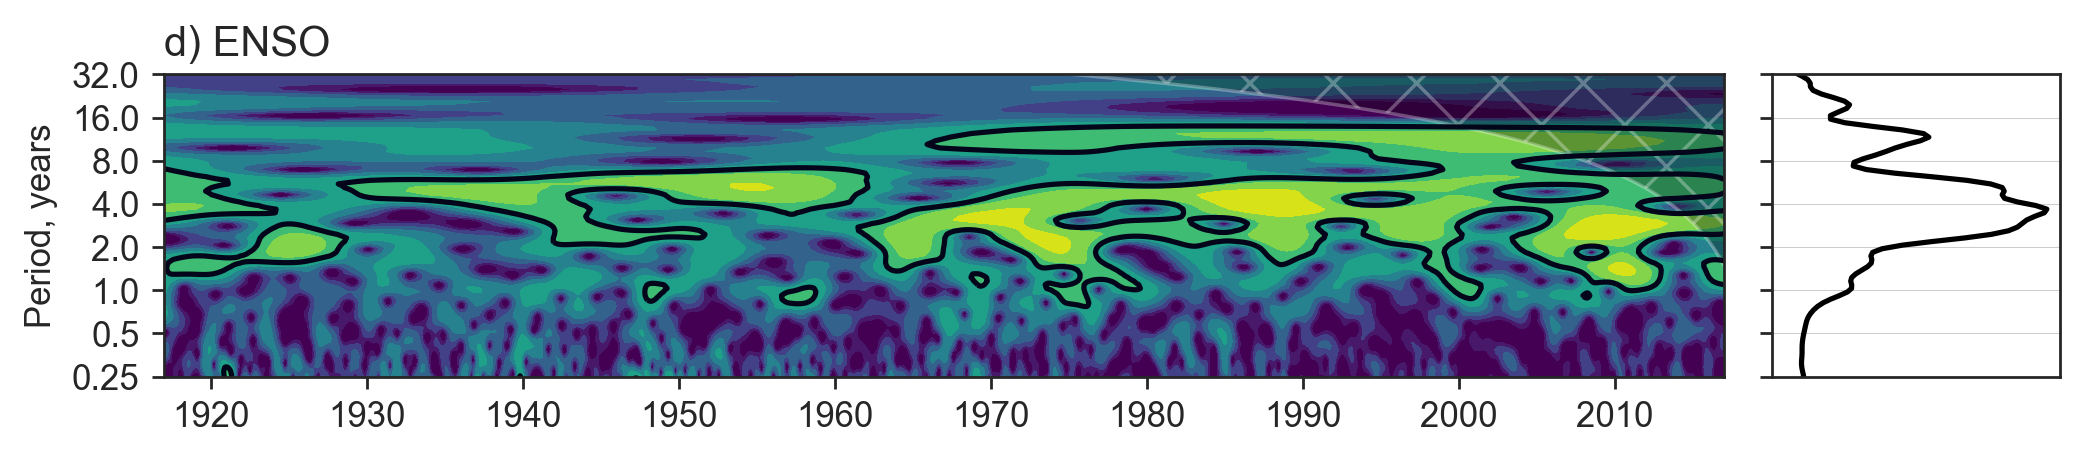

In [64]:
plt.close('all')
plt.ioff()
figprops = dict(figsize=(8*1.2, 1.6*1.2), dpi=250)
fig = plt.figure(**figprops)
bx = plt.axes([0.1, 0.2, 0.65, 0.63], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
            extend='both', cmap=plt.cm.viridis)
# bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels), colors='k', linewidths=2)
extent = [t.min(), t.max(), 0, max(period)]

bx.contour(t, np.log2(period), np.log2(power), np.log2([2]))

# bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
#            extent=extent)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                           np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.text(0,1.1, 'd) ENSO', horizontalalignment='left', verticalalignment='center', transform=bx.transAxes, fontsize='large')
# bx.set_title('Wavelet Power Spectrum')
bx.set_ylabel('Period, years')
#
# Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
#                            np.ceil(np.log2(period.max())))
Yticks = 2 ** np.arange(np.ceil(np.log2(0.25)),
                           np.ceil(np.log2(32.01)))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)
bx.set_xticks(np.arange(1920,2020,10))

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = plt.axes([0.77, 0.2, 0.12, 0.63], sharey=bx)
# cx.plot(glbl_signif, np.log2(period), 'k--')
# cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
# cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',linewidth=1.)
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
# cx.set_title('Global Power')
# cx.set_xlabel(r'Power')
# cx.set_xlim([0, glbl_power.max() + var])
# cx.set_xlim([0, glbl_power.max()/var/10])
cx.set_xticks([])
# cx.set_ylim(np.log2([period.min(), period.max()]))
cx.set_ylim(np.log2([0.25, 32.01]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
plt.setp(cx.get_yticklabels(), visible=False)
cx.grid(lw=0.3)
plt.tight_layout()
# fig.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Water Budget/latex_figures/img/freq_enso.pdf', dpi=fig.dpi)




In [1049]:
# nino_xticks = np.array([1917])
np.append(np.append([1917], np.arange(1930,2010,10)), [2017])

array([1917, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2017])

In [1039]:
nino_xticks.flatten()

AttributeError: 'list' object has no attribute 'flatten'

# El nino 3.4

In [913]:
nino34 = pd.read_csv('../../measurements/Oscillations/nino34.csv', skiprows=7)
# nino34 = nino34[nino34.Mean>-80]


for c in nino34.columns:
    nino34[c] = pd.to_numeric(nino34[c], errors='coerce')


nino34.head()

Year  January  February  March  April   May  June  July  August  September  \
0  1870    -1.00     -1.20  -0.83  -0.81 -1.27 -1.08 -1.04   -0.88      -0.53   
1  1871    -0.25     -0.58  -0.43  -0.50 -0.70 -0.53 -0.60   -0.33      -0.24   
2  1872    -0.72     -0.62  -0.50  -0.77 -0.62 -0.52 -0.32   -0.85      -1.02   
3  1873    -0.78     -1.01  -1.31  -0.67 -0.53 -0.48 -0.58   -0.39      -0.34   
4  1874    -0.93     -1.06  -1.40  -0.94 -0.86 -0.72 -1.00   -1.05      -1.13   

   October  November  December  
0    -0.92     -0.79     -0.79  
1    -0.33     -0.31     -0.58  
2    -0.94     -0.79     -0.88  
3    -0.78     -0.77     -0.70  
4    -1.25     -1.33     -1.14

In [914]:
nino34_agg = nino34.groupby('Year').mean()[nino34.columns[1:]].stack().reset_index()
nino34_agg['M_n'] = nino34_agg['level_1'].apply(lambda x: datetime.datetime.strptime(x, '%B').month)
nino34_agg['Year_dec']= nino34_agg['Year'] + nino34_agg['M_n']/12

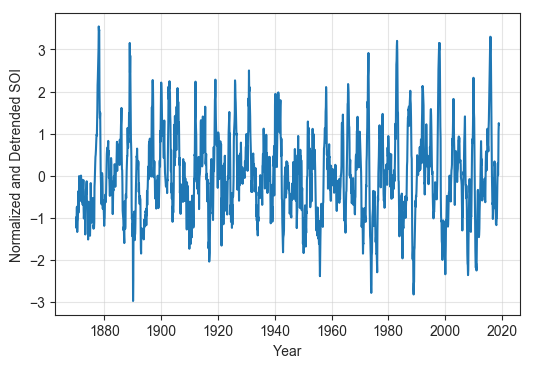

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


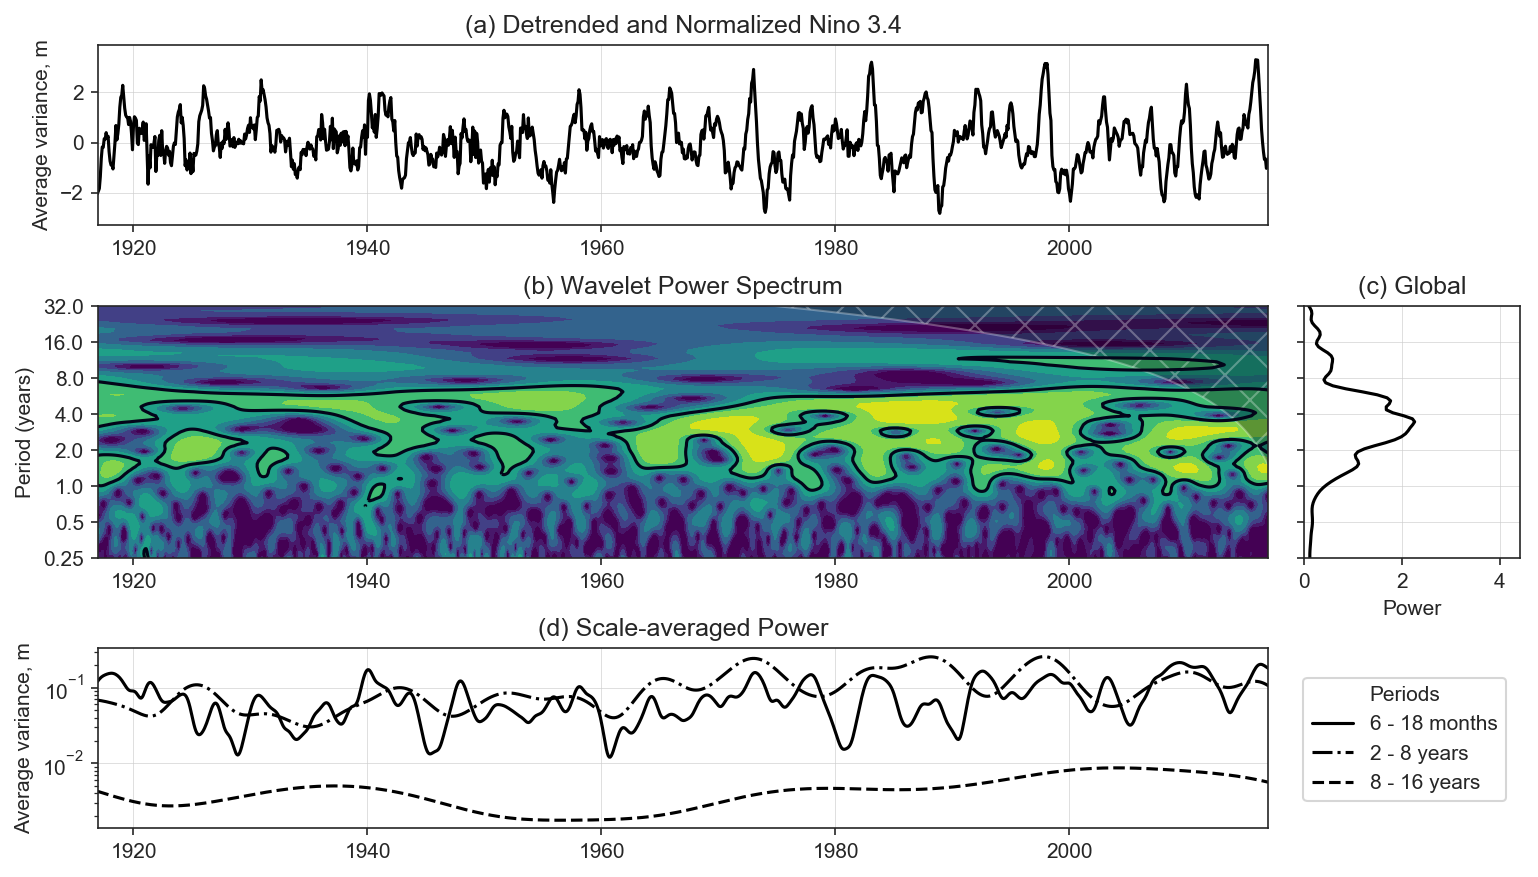

In [918]:
# t = discharge['Year_dec'].values
t = nino34_agg['Year_dec'].values
# t = Niagara_flow['Water Year'].values
t0 = t[0]
dt=1/12
dat =nino34_agg[0]
# dat = Niagara_flow['CFS'].values
N = dat.size

p = np.polyfit(t - t0, dat, 1)
dat_notrend = dat - np.polyval(p, t - t0)
std = dat_notrend.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset

fig,ax=plt.subplots(1,1,figsize=(6,4), dpi=100)
ax=sns.lineplot(t, dat_norm,ax=ax)

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes


# ax.legend(['({}) - {}'.format(selected_stations.index(site)+1, site)], loc=2, fontsize='small')
# ax.legend(['(11) - '+site], loc=2, fontsize='small')
# ax.set_ylim(0,None)
# ax.set_xlim(datetime.datetime(1928,1,1), datetime.datetime(2019,1,1))
ax.grid(alpha=0.5)
ax.set_ylabel("Normalized and Detrended SOI")
ax.set_xlabel("Year")

# axins = zoomed_inset_axes(ax, 8, loc='upper center')
# sns.lineplot(x='Date', y='Discharge, cms', data=discharge, hue='Source', ax=axins,zorder=10)
# axins.set_xlim(datetime.datetime(2010,4,1), datetime.datetime(2010,6,1)) # apply the x-limits
# axins.set_ylim(0, 10) # apply the y-limits
# plt.yticks(visible=False)
# plt.xticks(visible=False)
# from mpl_toolkits.axes_grid1.inset_locator import mark_inset
# mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")


plt.show()

mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 8 / dj  # Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

power = (np.abs(wave)) ** 2
fft_power = np.abs(fft) ** 2
period = 1 / freqs

power = power/scales[:, None]

signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = np.ones([1, N]) * signif[:, None]
sig95 = power / sig95

glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

sel = find((period >= 0.5) & (period <= 1.5))
Cdelta = mother.cdelta
scale_avg = (scales * np.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)


sel = find((period >= 2) & (period <= 8))
Cdelta = mother.cdelta
scale_avg_2 = (scales * np.ones((N, 1))).transpose()
scale_avg_2 = power / scale_avg_2  # As in Torrence and Compo (1998) equation 24
scale_avg_2 = var * dj * dt / Cdelta * scale_avg_2[sel, :].sum(axis=0)
scale_avg_signif_2, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

sel = find((period >= 8) & (period <= 16))
Cdelta = mother.cdelta
scale_avg_3 = (scales * np.ones((N, 1))).transpose()
scale_avg_3 = power / scale_avg_3  # As in Torrence and Compo (1998) equation 24
scale_avg_3 = var * dj * dt / Cdelta * scale_avg_3[sel, :].sum(axis=0)
scale_avg_signif_2, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

# Prepare the figure
plt.close('all')
plt.ioff()
figprops = dict(figsize=(12, 6), dpi=150)
fig = plt.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
# ax = plt.axes([0.1, 0.8, 0.65, 0.18])
# ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
# ax.plot(t, dat, 'k', linewidth=1.5)
# # ax.set_title('a) {}'.format(title))
# # ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = plt.axes([0.1, 0.38, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
            extend='both', cmap=plt.cm.viridis)
# bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels), colors='k', linewidths=2)
extent = [t.min(), t.max(), 0, max(period)]

bx.contour(t, np.log2(period), np.log2(power), np.log2([2]))

# bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
#            extent=extent)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                           np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('(b) Wavelet Power Spectrum')
bx.set_ylabel('Period (years)')
#
# Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
#                            np.ceil(np.log2(period.max())))
Yticks = 2 ** np.arange(np.ceil(np.log2(0.25)),
                           np.ceil(np.log2(32.01)))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)


# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = plt.axes([0.77, 0.38, 0.12, 0.28], sharey=bx)
# cx.plot(glbl_signif, np.log2(period), 'k--')
# cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
# cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',linewidth=1.)
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
cx.set_title('(c) Global')
cx.set_xlabel(r'Power')
cx.set_xlim([0, glbl_power.max() + var])
# cx.set_xlim([0, 0.5])
# cx.set_ylim(np.log2([period.min(), period.max()]))
cx.set_ylim(np.log2([0.25, 32.01]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
plt.setp(cx.get_yticklabels(), visible=False)
cx.grid(lw=0.3)


# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = plt.axes([0.1, 0.08, 0.65, 0.20], sharex=ax)
# dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.semilogy(t, scale_avg, 'k-', linewidth=1.5, label='6 - 18 months')
dx.semilogy(t, scale_avg_2, 'k-.', linewidth=1.5, label='2 - 8 years')
dx.semilogy(t, scale_avg_3, 'k--', linewidth=1.5, label='8 - 16 years')
dx.set_title('(d) Scale-averaged Power'.format(0.5, 1.5))
# dx.set_xlabel('Time (year)')
dx.legend(loc=(1.03,0.15), title='Periods')
dx.set_ylabel(r'Average variance, {}'.format(units))
ax.set_xlim([t.min(), t.max()])
dx.grid(lw=0.3)

# Fourth sub-plot, the scale averaged wavelet spectrum.
fx = plt.axes([0.1, 0.75, 0.65, 0.20], sharex=ax)
# dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
# fx.plot(t, scale_avg_2, 'k-', linewidth=1.5)
# fx.set_title('{}--{} year scale-averaged power'.format(3, 16))
# fx.set_xlabel('Time (year)')
# fx.set_ylabel(r'Average variance, {}'.format(units))
# # dx.set_ylabel(r'Average variance [{}]'.format(units))
# # fx.set_xlim([t.min(), t.max()])
# fx.grid(lw=0.3)

# ex = plt.axes([0.68, 0.14, 0.35, 0.45])
fx=sns.lineplot(t, dat_norm,ax=fx, c='k')
fx.set_title('(a) Detrended and Normalized Nino 3.4')
fx.set_ylabel(r'Average variance, {}'.format(units))
# fx.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
# fx.plot(t, dat, 'k', linewidth=1.5)
fx.grid(lw=0.3)
fx.set_xlim([t.min(), t.max()])
fx.set_xlim([1917, 2017])
plt.tight_layout()

# fig.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Water Budget/latex_figures/img/freq_analysis_nino34.pdf', dpi=f.dpi)




# El Nino 1+2

In [902]:
nino12 = pd.read_csv('../../measurements/Oscillations/nino12.csv', skiprows=8)
# nino12 = nino12[nino12.Mean>-80]


for c in nino12.columns:
    nino12[c] = pd.to_numeric(nino12[c], errors='coerce')


nino12.head()

Year  January  February  March  April   May  June  July  August  September  \
0  1870    -1.50     -0.96  -0.65  -0.32 -0.64 -0.96 -0.98   -1.02      -1.02   
1  1871    -0.74     -0.56  -0.78  -0.59 -0.76 -0.25 -0.34   -0.30      -0.35   
2  1872    -1.18     -1.25  -1.02  -0.70 -0.75 -0.60 -0.70   -0.83      -0.66   
3  1873    -0.88     -1.30  -1.83  -1.01 -1.12 -0.34 -0.29   -0.28      -0.68   
4  1874    -1.10     -1.46  -1.17  -0.94  0.07 -0.52 -0.77   -1.01      -0.73   

   October  November  December  
0    -1.53     -1.42     -1.25  
1    -0.15     -0.37     -1.04  
2    -0.87     -0.63     -0.83  
3    -0.97     -0.93     -0.91  
4    -0.77     -0.59     -0.80

In [903]:
nino12_agg = nino12.groupby('Year').mean()[nino12.columns[1:]].stack().reset_index()
nino12_agg['M_n'] = nino12_agg['level_1'].apply(lambda x: datetime.datetime.strptime(x, '%B').month)
nino12_agg['Year_dec']= nino12_agg['Year'] + nino12_agg['M_n']/12

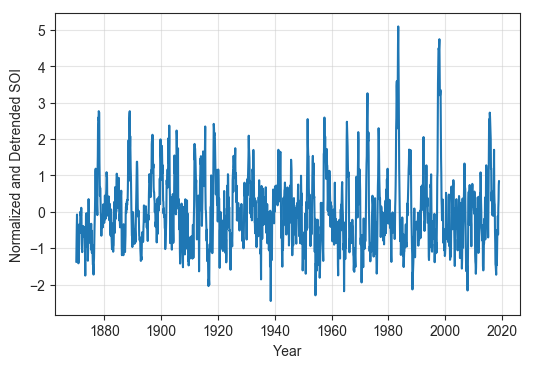

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


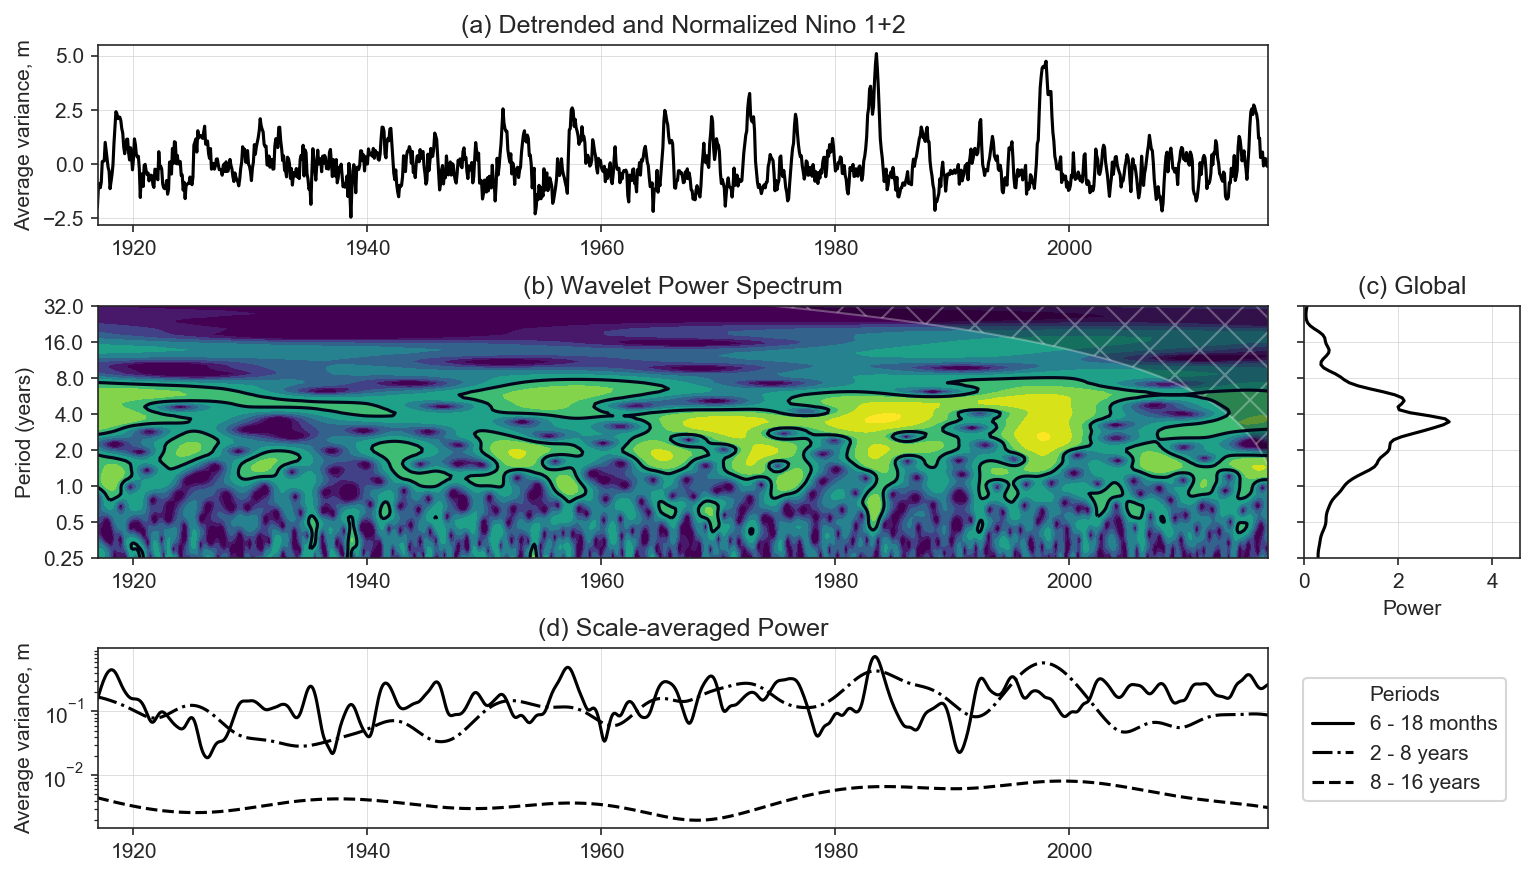

In [906]:
# t = discharge['Year_dec'].values
t = nino12_agg['Year_dec'].values
# t = Niagara_flow['Water Year'].values
t0 = t[0]
dt=1/12
dat =nino12_agg[0]
# dat = Niagara_flow['CFS'].values
N = dat.size

p = np.polyfit(t - t0, dat, 1)
dat_notrend = dat - np.polyval(p, t - t0)
std = dat_notrend.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset

fig,ax=plt.subplots(1,1,figsize=(6,4), dpi=100)
ax=sns.lineplot(t, dat_norm,ax=ax)

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes


# ax.legend(['({}) - {}'.format(selected_stations.index(site)+1, site)], loc=2, fontsize='small')
# ax.legend(['(11) - '+site], loc=2, fontsize='small')
# ax.set_ylim(0,None)
# ax.set_xlim(datetime.datetime(1928,1,1), datetime.datetime(2019,1,1))
ax.grid(alpha=0.5)
ax.set_ylabel("Normalized and Detrended SOI")
ax.set_xlabel("Year")

# axins = zoomed_inset_axes(ax, 8, loc='upper center')
# sns.lineplot(x='Date', y='Discharge, cms', data=discharge, hue='Source', ax=axins,zorder=10)
# axins.set_xlim(datetime.datetime(2010,4,1), datetime.datetime(2010,6,1)) # apply the x-limits
# axins.set_ylim(0, 10) # apply the y-limits
# plt.yticks(visible=False)
# plt.xticks(visible=False)
# from mpl_toolkits.axes_grid1.inset_locator import mark_inset
# mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")


plt.show()

mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 8 / dj  # Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

power = (np.abs(wave)) ** 2
fft_power = np.abs(fft) ** 2
period = 1 / freqs

power = power/scales[:, None]

signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = np.ones([1, N]) * signif[:, None]
sig95 = power / sig95

glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

sel = find((period >= 0.5) & (period <= 1.5))
Cdelta = mother.cdelta
scale_avg = (scales * np.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)


sel = find((period >= 2) & (period <= 8))
Cdelta = mother.cdelta
scale_avg_2 = (scales * np.ones((N, 1))).transpose()
scale_avg_2 = power / scale_avg_2  # As in Torrence and Compo (1998) equation 24
scale_avg_2 = var * dj * dt / Cdelta * scale_avg_2[sel, :].sum(axis=0)
scale_avg_signif_2, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

sel = find((period >= 8) & (period <= 16))
Cdelta = mother.cdelta
scale_avg_3 = (scales * np.ones((N, 1))).transpose()
scale_avg_3 = power / scale_avg_3  # As in Torrence and Compo (1998) equation 24
scale_avg_3 = var * dj * dt / Cdelta * scale_avg_3[sel, :].sum(axis=0)
scale_avg_signif_2, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

# Prepare the figure
plt.close('all')
plt.ioff()
figprops = dict(figsize=(12, 6), dpi=150)
fig = plt.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
# ax = plt.axes([0.1, 0.8, 0.65, 0.18])
# ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
# ax.plot(t, dat, 'k', linewidth=1.5)
# # ax.set_title('a) {}'.format(title))
# # ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = plt.axes([0.1, 0.38, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
            extend='both', cmap=plt.cm.viridis)
# bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels), colors='k', linewidths=2)
extent = [t.min(), t.max(), 0, max(period)]

bx.contour(t, np.log2(period), np.log2(power), np.log2([2]))

# bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
#            extent=extent)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                           np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('(b) Wavelet Power Spectrum')
bx.set_ylabel('Period (years)')
#
# Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
#                            np.ceil(np.log2(period.max())))
Yticks = 2 ** np.arange(np.ceil(np.log2(0.25)),
                           np.ceil(np.log2(32.01)))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)


# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = plt.axes([0.77, 0.38, 0.12, 0.28], sharey=bx)
# cx.plot(glbl_signif, np.log2(period), 'k--')
# cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
# cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',linewidth=1.)
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
cx.set_title('(c) Global')
cx.set_xlabel(r'Power')
cx.set_xlim([0, glbl_power.max() + var])
# cx.set_xlim([0, 0.5])
# cx.set_ylim(np.log2([period.min(), period.max()]))
cx.set_ylim(np.log2([0.25, 32.01]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
plt.setp(cx.get_yticklabels(), visible=False)
cx.grid(lw=0.3)


# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = plt.axes([0.1, 0.08, 0.65, 0.20], sharex=ax)
# dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.semilogy(t, scale_avg, 'k-', linewidth=1.5, label='6 - 18 months')
dx.semilogy(t, scale_avg_2, 'k-.', linewidth=1.5, label='2 - 8 years')
dx.semilogy(t, scale_avg_3, 'k--', linewidth=1.5, label='8 - 16 years')
dx.set_title('(d) Scale-averaged Power'.format(0.5, 1.5))
# dx.set_xlabel('Time (year)')
dx.legend(loc=(1.03,0.15), title='Periods')
dx.set_ylabel(r'Average variance, {}'.format(units))
ax.set_xlim([t.min(), t.max()])
dx.grid(lw=0.3)

# Fourth sub-plot, the scale averaged wavelet spectrum.
fx = plt.axes([0.1, 0.75, 0.65, 0.20], sharex=ax)
# dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
# fx.plot(t, scale_avg_2, 'k-', linewidth=1.5)
# fx.set_title('{}--{} year scale-averaged power'.format(3, 16))
# fx.set_xlabel('Time (year)')
# fx.set_ylabel(r'Average variance, {}'.format(units))
# # dx.set_ylabel(r'Average variance [{}]'.format(units))
# # fx.set_xlim([t.min(), t.max()])
# fx.grid(lw=0.3)

# ex = plt.axes([0.68, 0.14, 0.35, 0.45])
fx=sns.lineplot(t, dat_norm,ax=fx, c='k')
fx.set_title('(a) Detrended and Normalized Nino 1+2')
fx.set_ylabel(r'Average variance, {}'.format(units))
# fx.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
# fx.plot(t, dat, 'k', linewidth=1.5)
fx.grid(lw=0.3)
fx.set_xlim([t.min(), t.max()])
fx.set_xlim([1917, 2017])
plt.tight_layout()

# fig.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Water Budget/latex_figures/img/freq_analysis_nino12.pdf', dpi=f.dpi)




# Normilized scale-averaged wavelet power over 2-8-year band

(1917, 2017)

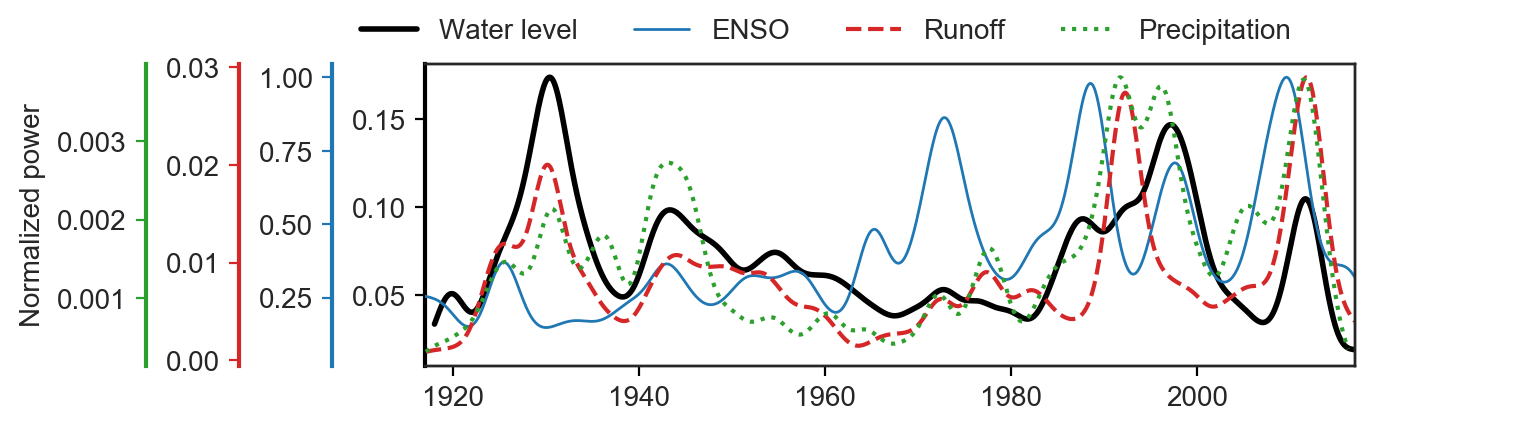

In [194]:
f, ax = plt.subplots(1,1, figsize=(6,2), dpi=200, sharex=True)


ax.plot(wl_t, wl_scale_avg_2/max([wl_scale_avg.max(), wl_scale_avg_2.max(), wl_scale_avg_3.max()]), 'k', lw=2, label='Water level')

ax2 = ax.twinx()

ax2.spines["left"].set_position(("axes", -0.1)) 
ax2.yaxis.set_label_position('left')
ax2.yaxis.set_ticks_position('left')

ax2.plot(enso_t, enso_scale_avg_2/max([enso_scale_avg.max(), enso_scale_avg_2.max(), enso_scale_avg_3.max()]), c=sns.color_palette()[0], lw=1, label='ENSO')


cx = ax.twinx()

cx.spines["left"].set_position(("axes", -0.2)) 
cx.yaxis.set_label_position('left')
cx.yaxis.set_ticks_position('left')

cx.plot(rf_t, rf_scale_avg_2/max([rf_scale_avg.max(), rf_scale_avg_2.max(), rf_scale_avg_3.max()]), ls='--', c=sns.color_palette()[3], label='Runoff')


dx = ax.twinx()

dx.spines["left"].set_position(("axes", -0.3)) 
dx.yaxis.set_label_position('left')
dx.yaxis.set_ticks_position('left')

dx.plot(prec_t, prec_scale_avg_2/max([prec_scale_avg.max(), prec_scale_avg_2.max(), prec_scale_avg_3.max()]), ls=':', c=sns.color_palette()[2], label='Precipitation')

dx.set_ylabel('Normalized power')

# ax.set_ylim(0, 1.1)


handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handlesc, labelsc = cx.get_legend_handles_labels()
handlesd, labelsd = dx.get_legend_handles_labels()
f.legend( handles + handles2 + handlesc + handlesd, labels + labels2+ labelsc+ labelsd , loc = (0.23, 0.87), ncol=4, frameon=0, framealpha=1, )

for ax, color in zip([ax, ax2, cx, dx], ['k', sns.color_palette()[0], sns.color_palette()[3], sns.color_palette()[2]]):
    plt.setp(ax.spines["left"], color=color)
    plt.setp(ax.spines["left"], lw=1.5)
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=color)

# sns.despine()
    
ax.set_xlim(1917,2017)




In [179]:
ax.spines

OrderedDict([('left', <matplotlib.spines.Spine at 0xa309284a8>),
             ('right', <matplotlib.spines.Spine at 0xa309285c0>),
             ('bottom', <matplotlib.spines.Spine at 0xa309286d8>),
             ('top', <matplotlib.spines.Spine at 0xa309287f0>)])